# **Newest Technique**

In [73]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import os
import time
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [74]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  2
TensorFlow version: 2.16.1


In [75]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [76]:
# Configuration parameters
CONFIG = {
    'IMG_HEIGHT': 64,
    'IMG_WIDTH': 64,
    'BATCH_SIZE': 128,
    'EPOCHS': 300,
    'INITIAL_LEARNING_RATE': 0.0001,
    'DATA_DIR': '/kaggle/input/dataset-new/Dataset(64x64)',  # Replace with your Kaggle dataset path
    'RESULTS_DIR': './BonoNet_Results/',
    'NUM_CLASSES': 171
}

In [77]:
# Create results directory
os.makedirs(CONFIG['RESULTS_DIR'], exist_ok=True)

In [78]:
def create_custom_cnn(input_shape=(64, 64, 3), num_classes=171):
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [79]:
def prepare_data():
    # Data Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomBrightness(0.2),
    ])
    
    # Load and split data
    train_ds = tf.keras.utils.image_dataset_from_directory(
        CONFIG['DATA_DIR'],
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH']),
        batch_size=CONFIG['BATCH_SIZE']
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        CONFIG['DATA_DIR'],
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH']),
        batch_size=CONFIG['BATCH_SIZE']
    )
    
    class_names = train_ds.class_names
    
    # Performance optimizations for Kaggle TPU/GPU
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Apply augmentation and preprocessing
    def preprocess_data(images, labels):
        images = data_augmentation(images)
        images = tf.cast(images, tf.float32) / 255.0
        return images, labels
    
    train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)
    
    # Use caching and prefetching
    train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    return train_ds, val_ds, class_names

In [80]:
def train_model(model, train_ds, val_ds):
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['INITIAL_LEARNING_RATE'])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(CONFIG['RESULTS_DIR'], 'best_model.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(CONFIG['RESULTS_DIR'], 'logs'),
            histogram_freq=1
        )
    ]
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CONFIG['EPOCHS'],
        callbacks=callbacks
    )
    
    return history

In [81]:
def evaluate_model(model, val_ds, class_names):
    # Prepare validation data
    val_images = []
    val_labels = []
    
    for images, labels in val_ds:
        val_images.append(images.numpy())
        val_labels.append(labels.numpy())
    
    val_images = np.concatenate(val_images, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    
    # Get predictions
    y_pred_proba = model.predict(val_images)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    return val_labels, y_pred, y_pred_proba

In [82]:
def save_evaluation_metrics(val_labels, y_pred, y_pred_proba, class_names, training_time):
    # Save classification report
    report = classification_report(val_labels, y_pred, target_names=class_names)
    with open(os.path.join(CONFIG['RESULTS_DIR'], 'classification_report.txt'), 'w') as f:
        f.write(f"Training Time: {training_time:.2f} seconds\n\n")
        f.write(report)
    
    # Save confusion matrix
    cm = confusion_matrix(val_labels, y_pred)
    plt.figure(figsize=(40, 40))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(CONFIG['RESULTS_DIR'], 'confusion_matrix.png'))
    plt.close()
    
    # Calculate and save per-class accuracy
    class_accuracies = []
    for i in range(len(class_names)):
        mask = (val_labels == i)
        class_acc = accuracy_score(val_labels[mask], y_pred[mask])
        class_accuracies.append(class_acc * 100)
    
    # Save per-class accuracies to CSV
    acc_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': class_accuracies
    })
    acc_df.to_csv(os.path.join(CONFIG['RESULTS_DIR'], 'per_class_accuracy.csv'))


In [83]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['RESULTS_DIR'], 'training_history.png'))
    plt.close()

In [85]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import os
import time
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import psutil
import warnings
warnings.filterwarnings('ignore')

In [86]:
def calculate_cpu_stats():
    """Calculate CPU usage statistics during training."""
    cpu_percent = psutil.cpu_percent(interval=1)
    memory = psutil.Process().memory_info().rss / 1024 / 1024  # in MB
    return {
        'cpu_percent': cpu_percent,
        'memory_usage_mb': memory
    }

In [87]:

def plot_roc_curves(y_true, y_pred_proba, class_names, save_dir):
    """Plot ROC curves for each class and micro/macro average."""
    plt.figure(figsize=(15, 10))
    
    # Binarize the labels for ROC curve calculation
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    # Calculate micro-average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Plot micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro, 
             label=f'micro-average ROC (AUC = {roc_auc_micro:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Calculate macro-average ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calculate macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'roc_curves.png'))
    plt.close()


In [88]:
def calculate_map(y_true, y_pred_proba, class_names):
    """Calculate Mean Average Precision (mAP)."""
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    # Calculate AP for each class
    ap_per_class = []
    for i in range(len(class_names)):
        ap = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
        ap_per_class.append(ap)
    
    # Calculate mAP
    mAP = np.mean(ap_per_class)
    return mAP, ap_per_class

In [89]:
def save_evaluation_metrics(val_labels, y_pred, y_pred_proba, class_names, training_time, history):
    results_dir = CONFIG['RESULTS_DIR']
    
    # Calculate overall metrics
    accuracy = accuracy_score(val_labels, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, y_pred, average='weighted')
    mAP, ap_per_class = calculate_map(val_labels, y_pred_proba, class_names)
    
    # Calculate CPU stats
    cpu_stats = calculate_cpu_stats()
    
    # Save comprehensive metrics report
    with open(os.path.join(results_dir, 'model_evaluation_report.txt'), 'w') as f:
        f.write("=== MODEL EVALUATION REPORT ===\n\n")
        f.write(f"Training Time: {training_time:.2f} seconds\n")
        f.write(f"CPU Usage: {cpu_stats['cpu_percent']:.1f}%\n")
        f.write(f"Memory Usage: {cpu_stats['memory_usage_mb']:.1f} MB\n\n")
        
        f.write("=== OVERALL METRICS ===\n")
        f.write(f"Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%\n")
        f.write(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%\n")
        f.write(f"Test Accuracy: {accuracy:.2f}%\n")
        f.write(f"Precision: {precision*100:.2f}%\n")
        f.write(f"Recall: {recall*100:.2f}%\n")
        f.write(f"F1 Score: {f1*100:.2f}%\n")
        f.write(f"Mean Average Precision (mAP): {mAP*100:.2f}%\n\n")
        
        f.write("=== CLASSIFICATION REPORT ===\n")
        f.write(classification_report(val_labels, y_pred, target_names=class_names))
    
    # Plot ROC curves
    plot_roc_curves(val_labels, y_pred_proba, class_names, results_dir)
    
    # Save per-class metrics to CSV
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Average_Precision': [ap * 100 for ap in ap_per_class],
        'Accuracy': [accuracy_score(val_labels == i, y_pred == i) * 100 for i in range(len(class_names))]
    })
    metrics_df.to_csv(os.path.join(results_dir, 'per_class_metrics.csv'))
    
    return {
        'accuracy': accuracy,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'mAP': mAP * 100,
        'training_time': training_time,
        'cpu_stats': cpu_stats
    }


In [90]:
def main():
    print("Starting Bangla Character Recognition Training...")
    print("\nConfiguration:")
    for key, value in CONFIG.items():
        print(f"{key}: {value}")
    
    # Prepare data
    print("\nPreparing data...")
    train_ds, val_ds, class_names = prepare_data()
    
    # Create and train model
    print("\nCreating and training model...")
    model = create_custom_cnn(
        input_shape=(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH'], 3),
        num_classes=CONFIG['NUM_CLASSES']
    )
    model.summary()
    
    start_time = time.time()
    history = train_model(model, train_ds, val_ds)
    training_time = time.time() - start_time
    
    # Evaluate model
    print("\nEvaluating model...")
    val_labels, y_pred, y_pred_proba = evaluate_model(model, val_ds, class_names)
    
    # Save results and get metrics
    print("\nSaving results...")
    metrics = save_evaluation_metrics(val_labels, y_pred, y_pred_proba, class_names, training_time, history)
    plot_training_history(history)
    
    # Print final metrics
    print("\n=== FINAL MODEL METRICS ===")
    print(f"Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
    print(f"Test Accuracy: {metrics['accuracy']:.2f}%")
    print(f"Precision: {metrics['precision']:.2f}%")
    print(f"Recall: {metrics['recall']:.2f}%")
    print(f"F1 Score: {metrics['f1']:.2f}%")
    print(f"Mean Average Precision (mAP): {metrics['mAP']:.2f}%")
    print(f"\nTraining Time: {metrics['training_time']:.2f} seconds")
    print(f"CPU Usage: {metrics['cpu_stats']['cpu_percent']:.1f}%")
    print(f"Memory Usage: {metrics['cpu_stats']['memory_usage_mb']:.1f} MB")
    
    print(f"\nDetailed results saved in {CONFIG['RESULTS_DIR']}")

if __name__ == "__main__":
    main()

Starting Bangla Character Recognition Training...

Configuration:
IMG_HEIGHT: 64
IMG_WIDTH: 64
BATCH_SIZE: 128
EPOCHS: 300
INITIAL_LEARNING_RATE: 0.0001
DATA_DIR: /kaggle/input/dataset-new/Dataset(64x64)
RESULTS_DIR: ./BonoNet_Results/
NUM_CLASSES: 171

Preparing data...
Found 51300 files belonging to 171 classes.
Using 41040 files for training.
Found 51300 files belonging to 171 classes.
Using 10260 files for validation.

Creating and training model...


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 16, 16, 128)    │             

 Total params: 4,661,963 (17.78 MB)

 Trainable params: 4,659,531 (17.77 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/300
320/321 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0068 - loss: 6.9230
Epoch 1: val_accuracy improved from -inf to 0.00838, saving model to ./BonoNet_Results/best_model.keras
321/321 ━━━━━━━━━━━━━━━━━━━━ 73s 100ms/step - accuracy: 0.0068 - loss: 6.9224 - val_accuracy: 0.0084 - val_loss: 6.4466 - learning_rate: 1.0000e-04
Epoch 2/300
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0118 - loss: 6.6027
Epoch 2: val_accuracy improved from 0.00838 to 0.04581, saving model to ./BonoNet_Results/best_model.keras
321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.0118 - loss: 6.6025 - val_accuracy: 0.0458 - val_loss: 6.0406 - learning_rate: 1.0000e-04
Epoch 3/300
320/321 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0129 - loss: 6.4142
Epoch 3: val_accuracy did not improve from 0.04581
321/321 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.0129 - loss: 6.4139 - val_accuracy: 0.0374 - val_loss: 5.9070 - learning_rate: 1.0000e-04
Epoch 4/300
320/321 ━━━━━━━━━━━━

# **Another Technique**

In [116]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import os
import time
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [117]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  2
TensorFlow version: 2.16.1


In [118]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [121]:
# Configuration parameters
CONFIG = {
    'IMG_HEIGHT': 64,
    'IMG_WIDTH': 64,
    'BATCH_SIZE': 512,
    'EPOCHS': 300,
    'INITIAL_LEARNING_RATE': 0.0001,
    'DATA_DIR': '/kaggle/input/dataset-new/Dataset(64x64)',  # Replace with your Kaggle dataset path
    'RESULTS_DIR': './BonoNet_Results3/',
    'NUM_CLASSES': 171
}

In [122]:
# Create results directory
os.makedirs(CONFIG['RESULTS_DIR'], exist_ok=True)

In [123]:
def create_custom_cnn(input_shape=(64, 64, 3), num_classes=171):
    model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [124]:
def prepare_data():
    # Data Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomBrightness(0.2),
    ])
    
    # Load and split data
    train_ds = tf.keras.utils.image_dataset_from_directory(
        CONFIG['DATA_DIR'],
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH']),
        batch_size=CONFIG['BATCH_SIZE']
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        CONFIG['DATA_DIR'],
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH']),
        batch_size=CONFIG['BATCH_SIZE']
    )
    
    class_names = train_ds.class_names
    
    # Performance optimizations for Kaggle TPU/GPU
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Apply augmentation and preprocessing
    def preprocess_data(images, labels):
        images = data_augmentation(images)
        images = tf.cast(images, tf.float32) / 255.0
        return images, labels
    
    train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)
    
    # Use caching and prefetching
    train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    return train_ds, val_ds, class_names

In [125]:
def train_model(model, train_ds, val_ds):
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['INITIAL_LEARNING_RATE'])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(CONFIG['RESULTS_DIR'], 'best_model3.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-5,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(CONFIG['RESULTS_DIR'], 'logs'),
            histogram_freq=1
        )
    ]
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CONFIG['EPOCHS'],
        callbacks=callbacks
    )
    
    return history

In [126]:
def evaluate_model(model, val_ds, class_names):
    # Prepare validation data
    val_images = []
    val_labels = []
    
    for images, labels in val_ds:
        val_images.append(images.numpy())
        val_labels.append(labels.numpy())
    
    val_images = np.concatenate(val_images, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    
    # Get predictions
    y_pred_proba = model.predict(val_images)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    return val_labels, y_pred, y_pred_proba

In [127]:
def save_evaluation_metrics(val_labels, y_pred, y_pred_proba, class_names, training_time):
    # Save classification report
    report = classification_report(val_labels, y_pred, target_names=class_names)
    with open(os.path.join(CONFIG['RESULTS_DIR'], 'classification_report.txt'), 'w') as f:
        f.write(f"Training Time: {training_time:.2f} seconds\n\n")
        f.write(report)
    
    # Save confusion matrix
    cm = confusion_matrix(val_labels, y_pred)
    plt.figure(figsize=(40, 40))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(CONFIG['RESULTS_DIR'], 'confusion_matrix.png'))
    plt.close()
    
    # Calculate and save per-class accuracy
    class_accuracies = []
    for i in range(len(class_names)):
        mask = (val_labels == i)
        class_acc = accuracy_score(val_labels[mask], y_pred[mask])
        class_accuracies.append(class_acc * 100)
    
    # Save per-class accuracies to CSV
    acc_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': class_accuracies
    })
    acc_df.to_csv(os.path.join(CONFIG['RESULTS_DIR'], 'per_class_accuracy.csv'))


In [128]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['RESULTS_DIR'], 'training_history.png'))
    plt.close()

In [129]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import os
import time
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import psutil
import warnings
warnings.filterwarnings('ignore')

In [130]:
def calculate_cpu_stats():
    """Calculate CPU usage statistics during training."""
    cpu_percent = psutil.cpu_percent(interval=1)
    memory = psutil.Process().memory_info().rss / 1024 / 1024  # in MB
    return {
        'cpu_percent': cpu_percent,
        'memory_usage_mb': memory
    }

In [131]:

def plot_roc_curves(y_true, y_pred_proba, class_names, save_dir):
    """Plot ROC curves for each class and micro/macro average."""
    plt.figure(figsize=(15, 10))
    
    # Binarize the labels for ROC curve calculation
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    # Calculate micro-average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Plot micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro, 
             label=f'micro-average ROC (AUC = {roc_auc_micro:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Calculate macro-average ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calculate macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'roc_curves.png'))
    plt.close()


In [132]:
def calculate_map(y_true, y_pred_proba, class_names):
    """Calculate Mean Average Precision (mAP)."""
    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_true)
    
    # Calculate AP for each class
    ap_per_class = []
    for i in range(len(class_names)):
        ap = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
        ap_per_class.append(ap)
    
    # Calculate mAP
    mAP = np.mean(ap_per_class)
    return mAP, ap_per_class

In [133]:
def save_evaluation_metrics(val_labels, y_pred, y_pred_proba, class_names, training_time, history):
    results_dir = CONFIG['RESULTS_DIR']
    
    # Calculate overall metrics
    accuracy = accuracy_score(val_labels, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, y_pred, average='weighted')
    mAP, ap_per_class = calculate_map(val_labels, y_pred_proba, class_names)
    
    # Calculate CPU stats
    cpu_stats = calculate_cpu_stats()
    
    # Save comprehensive metrics report
    with open(os.path.join(results_dir, 'model_evaluation_report.txt'), 'w') as f:
        f.write("=== MODEL EVALUATION REPORT ===\n\n")
        f.write(f"Training Time: {training_time:.2f} seconds\n")
        f.write(f"CPU Usage: {cpu_stats['cpu_percent']:.1f}%\n")
        f.write(f"Memory Usage: {cpu_stats['memory_usage_mb']:.1f} MB\n\n")
        
        f.write("=== OVERALL METRICS ===\n")
        f.write(f"Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%\n")
        f.write(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%\n")
        f.write(f"Test Accuracy: {accuracy:.2f}%\n")
        f.write(f"Precision: {precision*100:.2f}%\n")
        f.write(f"Recall: {recall*100:.2f}%\n")
        f.write(f"F1 Score: {f1*100:.2f}%\n")
        f.write(f"Mean Average Precision (mAP): {mAP*100:.2f}%\n\n")
        
        f.write("=== CLASSIFICATION REPORT ===\n")
        f.write(classification_report(val_labels, y_pred, target_names=class_names))
    
    # Plot ROC curves
    plot_roc_curves(val_labels, y_pred_proba, class_names, results_dir)
    
    # Save per-class metrics to CSV
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Average_Precision': [ap * 100 for ap in ap_per_class],
        'Accuracy': [accuracy_score(val_labels == i, y_pred == i) * 100 for i in range(len(class_names))]
    })
    metrics_df.to_csv(os.path.join(results_dir, 'per_class_metrics.csv'))
    
    return {
        'accuracy': accuracy,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'mAP': mAP * 100,
        'training_time': training_time,
        'cpu_stats': cpu_stats
    }


In [ ]:
def main():
    print("Starting Bangla Character Recognition Training...")
    print("\nConfiguration:")
    for key, value in CONFIG.items():
        print(f"{key}: {value}")
    
    # Prepare data
    print("\nPreparing data...")
    train_ds, val_ds, class_names = prepare_data()
    
    # Create and train model
    print("\nCreating and training model...")
    model = create_custom_cnn(
        input_shape=(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH'], 3),
        num_classes=CONFIG['NUM_CLASSES']
    )
    model.summary()
    
    start_time = time.time()
    history = train_model(model, train_ds, val_ds)
    training_time = time.time() - start_time
    
    # Evaluate model
    print("\nEvaluating model...")
    val_labels, y_pred, y_pred_proba = evaluate_model(model, val_ds, class_names)
    
    # Save results and get metrics
    print("\nSaving results...")
    metrics = save_evaluation_metrics(val_labels, y_pred, y_pred_proba, class_names, training_time, history)
    plot_training_history(history)
    
    # Print final metrics
    print("\n=== FINAL MODEL METRICS ===")
    print(f"Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
    print(f"Test Accuracy: {metrics['accuracy']:.2f}%")
    print(f"Precision: {metrics['precision']:.2f}%")
    print(f"Recall: {metrics['recall']:.2f}%")
    print(f"F1 Score: {metrics['f1']:.2f}%")
    print(f"Mean Average Precision (mAP): {metrics['mAP']:.2f}%")
    print(f"\nTraining Time: {metrics['training_time']:.2f} seconds")
    print(f"CPU Usage: {metrics['cpu_stats']['cpu_percent']:.1f}%")
    print(f"Memory Usage: {metrics['cpu_stats']['memory_usage_mb']:.1f} MB")
    
    print(f"\nDetailed results saved in {CONFIG['RESULTS_DIR']}")

if __name__ == "__main__":
    main()

Starting Bangla Character Recognition Training...

Configuration:
IMG_HEIGHT: 64
IMG_WIDTH: 64
BATCH_SIZE: 512
EPOCHS: 300
INITIAL_LEARNING_RATE: 0.0001
DATA_DIR: /kaggle/input/dataset-new/Dataset(64x64)
RESULTS_DIR: ./BonoNet_Results3/
NUM_CLASSES: 171

Preparing data...
Found 51300 files belonging to 171 classes.
Using 41040 files for training.
Found 51300 files belonging to 171 classes.
Using 10260 files for validation.

Creating and training model...


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 16, 16, 128)    │             

 Total params: 4,661,963 (17.78 MB)

 Trainable params: 4,659,531 (17.77 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.0066 - loss: 6.9535
Epoch 1: val_accuracy improved from -inf to 0.00526, saving model to ./BonoNet_Results3/best_model3.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 75s 315ms/step - accuracy: 0.0066 - loss: 6.9527 - val_accuracy: 0.0053 - val_loss: 6.4641 - learning_rate: 1.0000e-04
Epoch 2/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.0087 - loss: 6.7422
Epoch 2: val_accuracy improved from 0.00526 to 0.00595, saving model to ./BonoNet_Results3/best_model3.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.0087 - loss: 6.7418 - val_accuracy: 0.0059 - val_loss: 6.4935 - learning_rate: 1.0000e-04
Epoch 3/300
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.0113 - loss: 6.6046
Epoch 3: val_accuracy improved from 0.00595 to 0.00760, saving model to ./BonoNet_Results3/best_model3.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 194ms/step - accuracy: 0.0113 - loss: 6.6043 - val_accuracy: 0.0076 - val_loss: 6.4893 - lea

# **Ensamble Technique**

Loading and preprocessing data...
Creating models...
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training models...
Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729832872.461581     116 service.cc:145] XLA service 0x7b4814002140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729832872.461648     116 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729832872.461652     116 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1283 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.0035 - loss: 5.2106        

I0000 00:00:1729832905.415680     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 149s 79ms/step - accuracy: 0.0055 - loss: 5.1999 - val_accuracy: 0.0058 - val_loss: 5.1442
Epoch 2/150
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.0049 - loss: 5.1463 - val_accuracy: 0.0058 - val_loss: 5.1421
Epoch 3/150
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.0054 - loss: 5.1437 - val_accuracy: 0.0058 - val_loss: 5.1419
Epoch 4/150
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.0043 - loss: 5.1433 - val_accuracy: 0.0058 - val_loss: 5.1420
Epoch 5/150
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.0053 - loss: 5.1437 - val_accuracy: 0.0058 - val_loss: 5.1419
Epoch 6/150
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - accuracy: 0.0052 - loss: 5.1438 - val_accuracy: 0.0058 - val_loss: 5.1425
Epoch 7/150
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 61s 47ms/step - accuracy: 0.0059 - loss: 5.1455 - val_accuracy: 0.0058 - val_loss: 5.1421
Epoch 8/150
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - accuracy: 0.0056 - lo

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


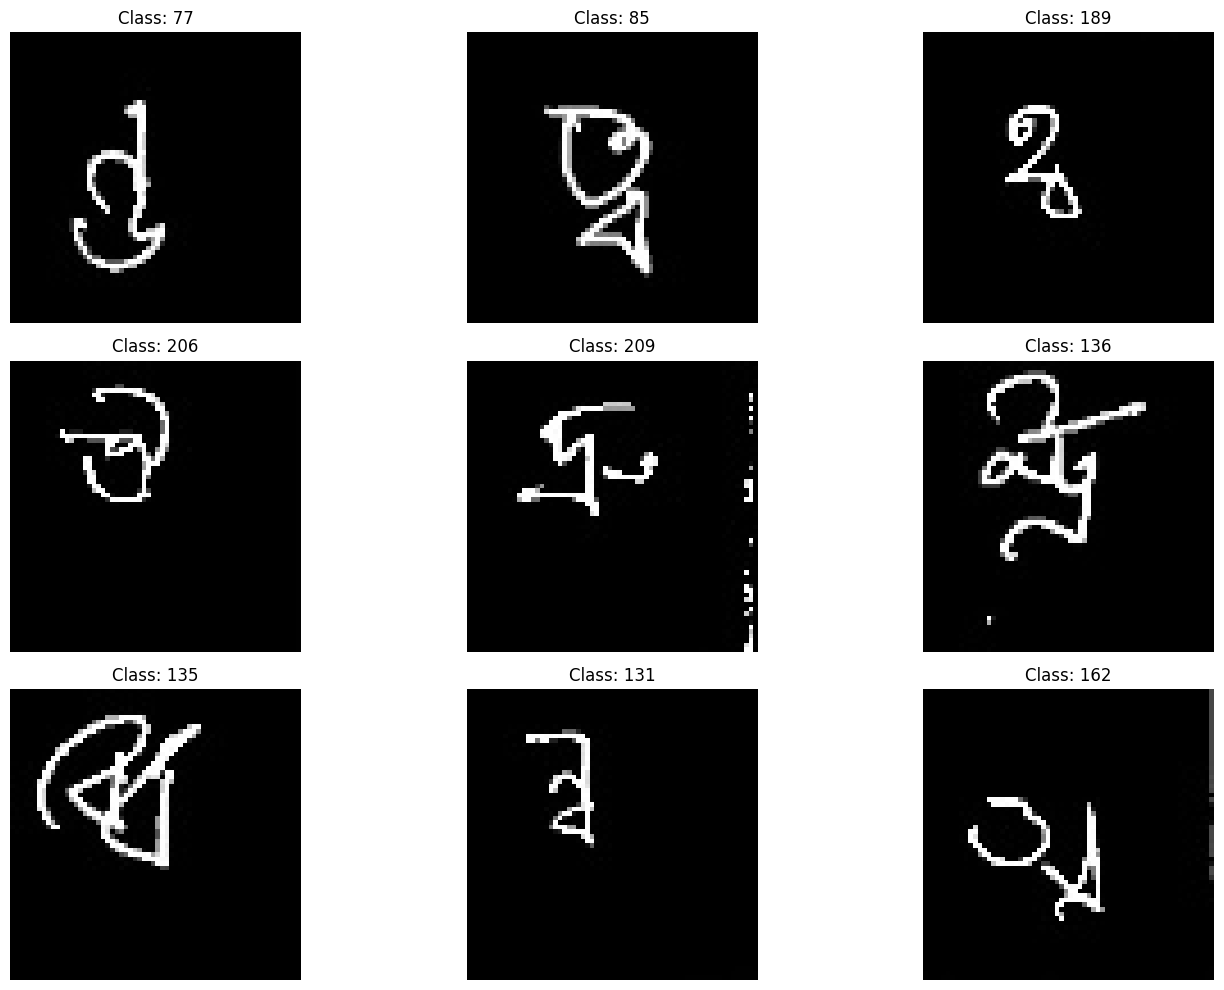

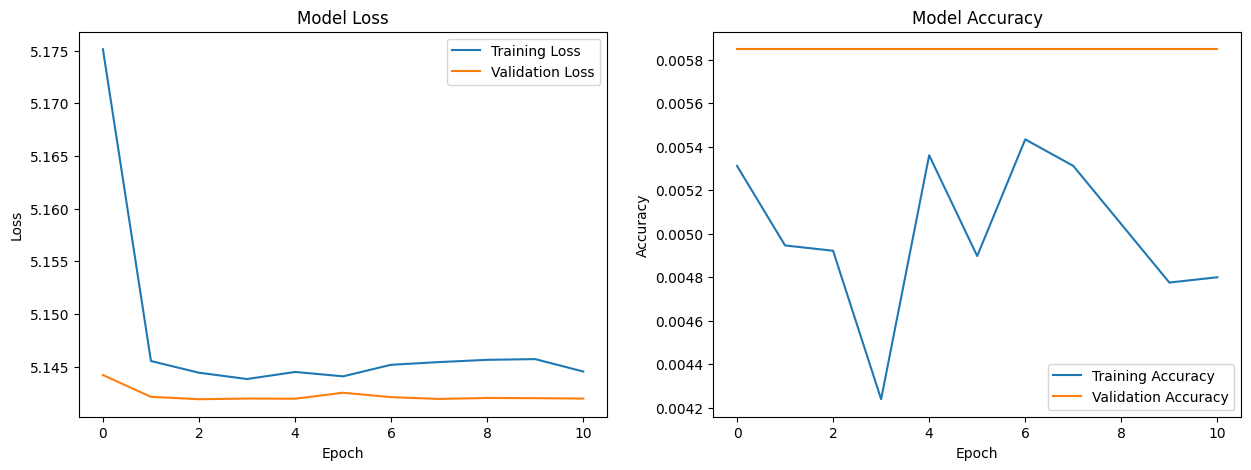

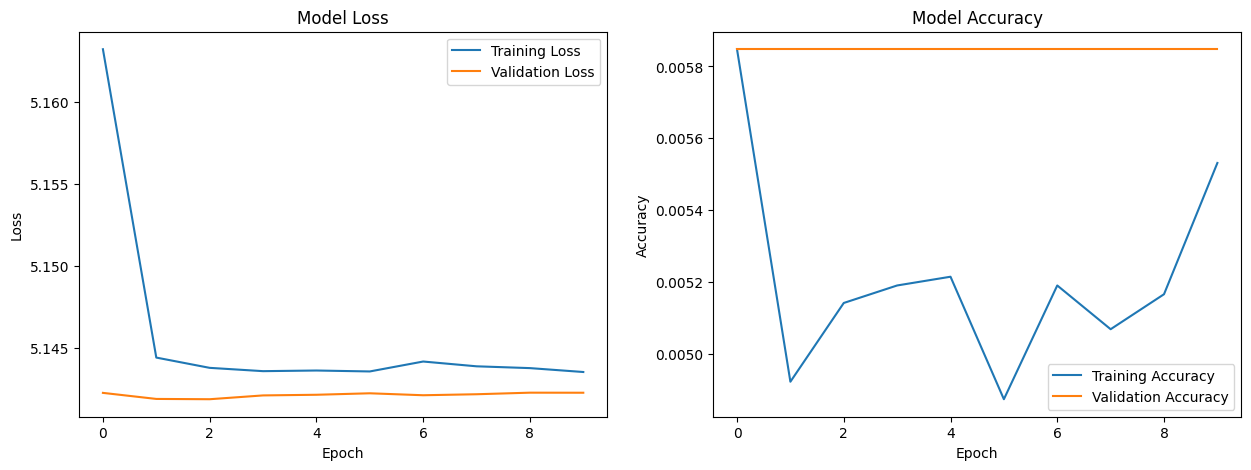

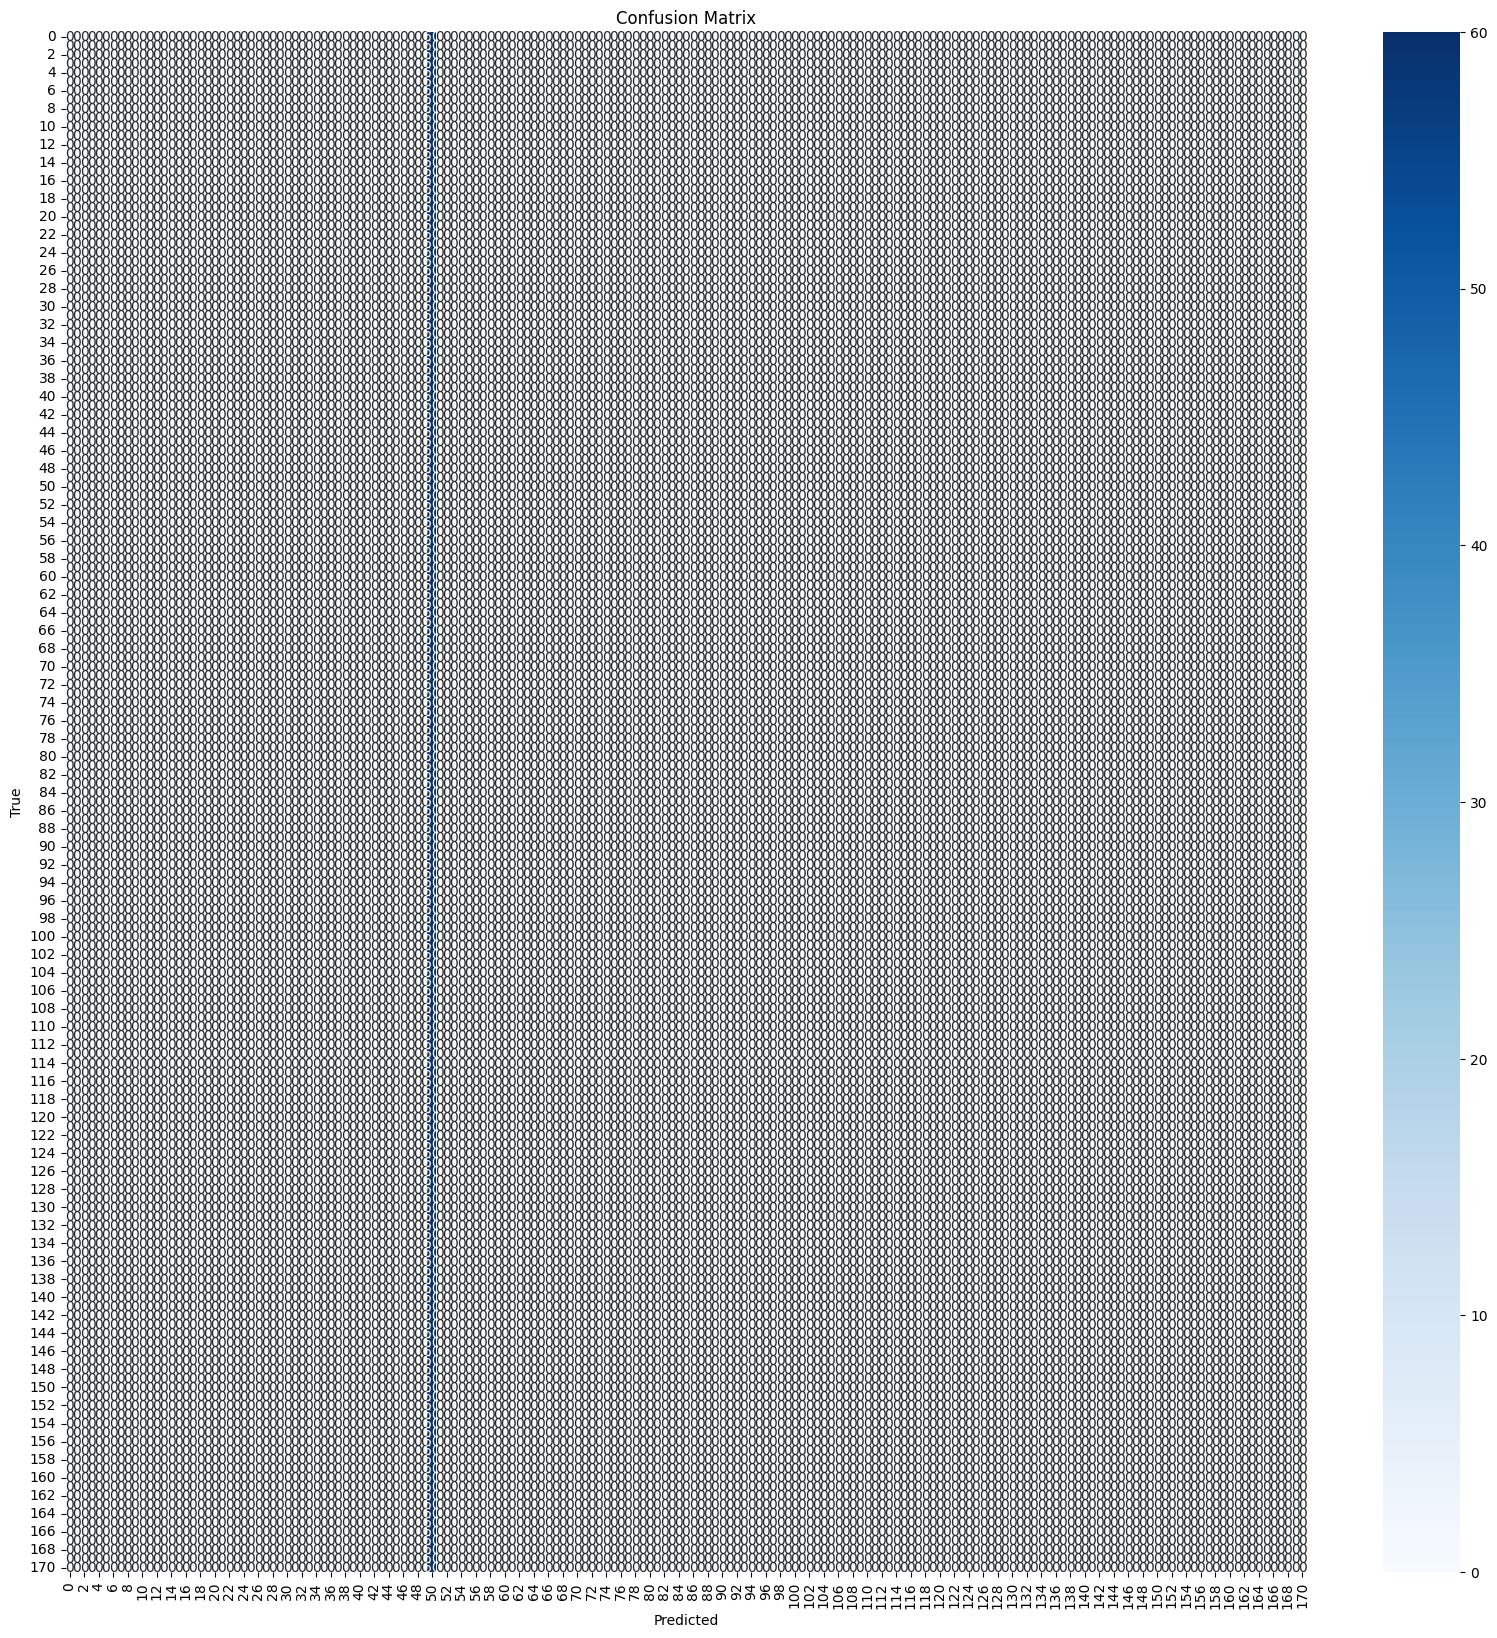

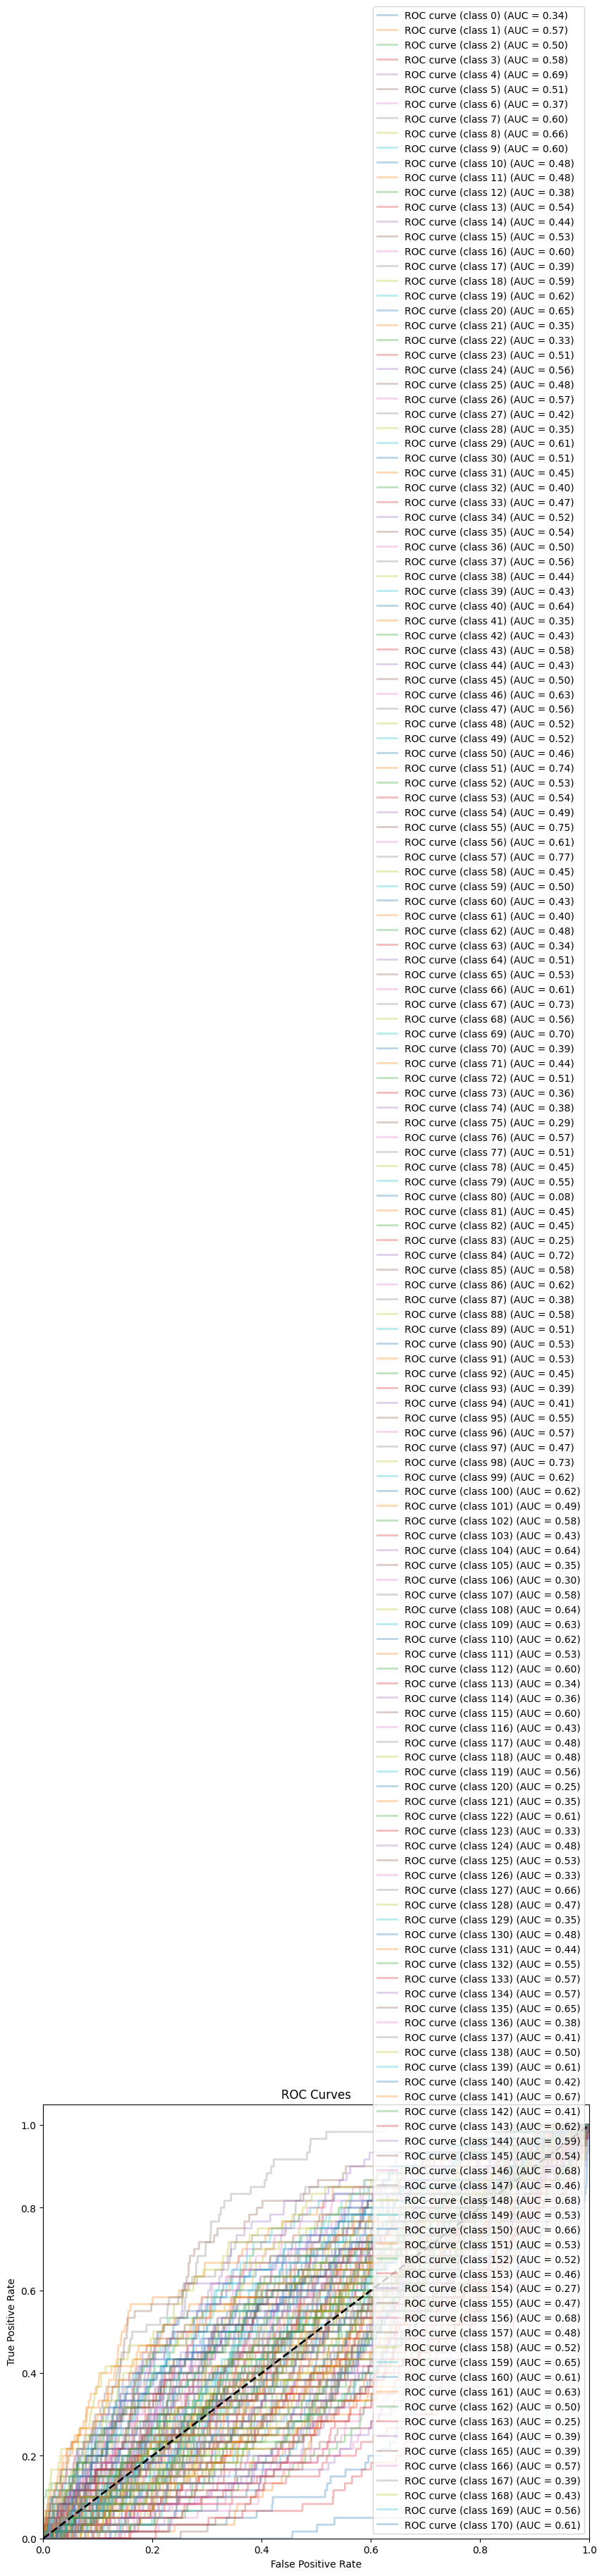


Training Time: 1414.9701993465424 seconds

Classification Report:
              precision    recall  f1-score   support

         100       0.00      0.00      0.00        60
         101       0.00      0.00      0.00        60
         102       0.00      0.00      0.00        60
         103       0.00      0.00      0.00        60
         104       0.00      0.00      0.00        60
         105       0.00      0.00      0.00        60
         106       0.00      0.00      0.00        60
         107       0.00      0.00      0.00        60
         108       0.00      0.00      0.00        60
         109       0.00      0.00      0.00        60
         110       0.00      0.00      0.00        60
         111       0.00      0.00      0.00        60
         112       0.00      0.00      0.00        60
         113       0.00      0.00      0.00        60
         114       0.00      0.00      0.00        60
         115       0.00      0.00      0.00        60
         116  

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1, EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import time
from tensorflow.keras.callbacks import EarlyStopping
import os

# Custom Swish activation
def swish(x):
    return x * tf.sigmoid(x)

# Data loading and preprocessing
def load_and_preprocess_data(data_dir, img_size=64):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = tf.keras.preprocessing.image.load_img(
                img_path, color_mode='grayscale', target_size=(img_size, img_size)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(idx)
    
    return np.array(images), np.array(labels), class_names

# Visualization functions
def plot_sample_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Class: {class_names[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(
            (y_true == i).astype(int), 
            y_pred_proba[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(
            fpr[i], 
            tpr[i], 
            lw=2, 
            alpha=0.3,
            label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})'
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# Model creation functions
def create_efficient_net_model(model_type, img_size, num_classes):
    if model_type == 'B1':
        base_model = EfficientNetB1(
            weights='imagenet',
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    else:
        base_model = EfficientNetB2(
            weights='imagenet',
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation=swish)(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation=swish)(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

# Main execution
def main():
    # Parameters
    IMG_SIZE = 64
    BATCH_SIZE = 32
    EPOCHS = 150
    DATA_DIR = '/kaggle/input/dataset-new/Dataset(64x64)'  # Update this path
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    images, labels, class_names = load_and_preprocess_data(DATA_DIR, IMG_SIZE)
    
    # Convert grayscale to RGB (required for EfficientNet)
    images = np.repeat(images, 3, axis=-1)
    
    # Normalize images
    images = images / 255.0
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest'
    )
    
    # Create and compile models
    print("Creating models...")
    model_b1 = create_efficient_net_model('B1', IMG_SIZE, len(class_names))
    model_b2 = create_efficient_net_model('B2', IMG_SIZE, len(class_names))
    
    # Compile models
    for model in [model_b1, model_b2]:
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )
    
    # Train models
    print("Training models...")
    start_time = time.time()
    
    history_b1 = model_b1.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    
    history_b2 = model_b2.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    
    training_time = time.time() - start_time
    
    # Ensemble predictions
    print("Making predictions...")
    pred_proba_b1 = model_b1.predict(X_test)
    pred_proba_b2 = model_b2.predict(X_test)
    
    # Average predictions from both models
    ensemble_pred_proba = (pred_proba_b1 + pred_proba_b2) / 2
    ensemble_pred = np.argmax(ensemble_pred_proba, axis=1)
    
    # Calculate metrics
    classification_rep = classification_report(
        y_test, 
        ensemble_pred, 
        target_names=class_names
    )
    
    # Visualizations
    print("Generating visualizations...")
    plot_sample_images(X_test, y_test, class_names)
    plot_training_history(history_b1)
    plot_training_history(history_b2)
    plot_confusion_matrix(y_test, ensemble_pred, class_names)
    plot_roc_curve(y_test, ensemble_pred_proba, len(class_names))
    
    # Print results
    print("\nTraining Time:", training_time, "seconds")
    print("\nClassification Report:")
    print(classification_rep)
    
    # Calculate and print accuracy percentage
    accuracy = (ensemble_pred == y_test).mean() * 100
    print(f"\nEnsemble Model Accuracy: {accuracy:.2f}%")

if __name__ == "__main__":
    main()

# **New 28-10-24**

Number of devices: 2
Found 51300 files belonging to 171 classes.
Using 38475 files for training.
Found 51300 files belonging to 171 classes.
Using 12825 files for validation.

Training ConvNeXtTiny
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 2, 2, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 171)            │        11,115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,257,803 (107.79 MB)

 Trainable params: 437,675 (1.67 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

Epoch 1/40


I0000 00:00:1730179889.264150      99 service.cc:145] XLA service 0x78ecd4a9c9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730179889.264200      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730179889.264205      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730179889.578345      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


602/602 ━━━━━━━━━━━━━━━━━━━━ 103s 127ms/step - accuracy: 0.0061 - loss: 11.4486 - val_accuracy: 0.0092 - val_loss: 8.0524 - learning_rate: 1.0000e-04
Epoch 2/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.0070 - loss: 7.4385 - val_accuracy: 0.0164 - val_loss: 6.2173 - learning_rate: 1.0000e-04
Epoch 3/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.0086 - loss: 6.0261 - val_accuracy: 0.0211 - val_loss: 5.6285 - learning_rate: 1.0000e-04
Epoch 4/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.0107 - loss: 5.5662 - val_accuracy: 0.0259 - val_loss: 5.3642 - learning_rate: 1.0000e-04
Epoch 5/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.0154 - loss: 5.3465 - val_accuracy: 0.0235 - val_loss: 5.2047 - learning_rate: 1.0000e-04
Epoch 6/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.0172 - loss: 5.2141 - val_accuracy: 0.0318 - val_loss: 5.0754 - learning_rate: 1.0000e-04
Epoch 7/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accu

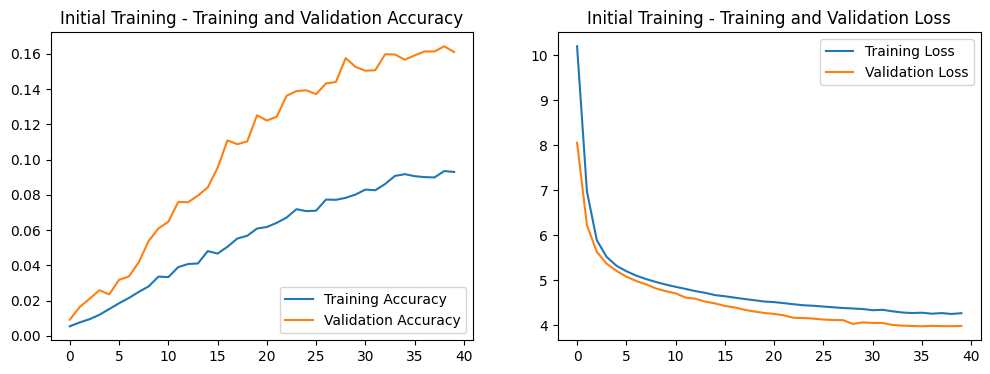


Initial Training CPU Time: 1332.31 seconds

Fine-tuning the model
Epoch 1/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 177s 216ms/step - accuracy: 0.0967 - loss: 4.1808 - val_accuracy: 0.1891 - val_loss: 3.6667 - learning_rate: 1.0000e-05
Epoch 2/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.1115 - loss: 3.9935 - val_accuracy: 0.2060 - val_loss: 3.5253 - learning_rate: 1.0000e-05
Epoch 3/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.1216 - loss: 3.8836 - val_accuracy: 0.2222 - val_loss: 3.4195 - learning_rate: 1.0000e-05
Epoch 4/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.1251 - loss: 3.8092 - val_accuracy: 0.2351 - val_loss: 3.3468 - learning_rate: 1.0000e-05
Epoch 5/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.1329 - loss: 3.7507 - val_accuracy: 0.2486 - val_loss: 3.2556 - learning_rate: 1.0000e-05
Epoch 6/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 121s 201ms/step - accuracy: 0.1387 - loss: 3.6986 - val_accuracy: 0.2514 - val_loss: 3.2445 -

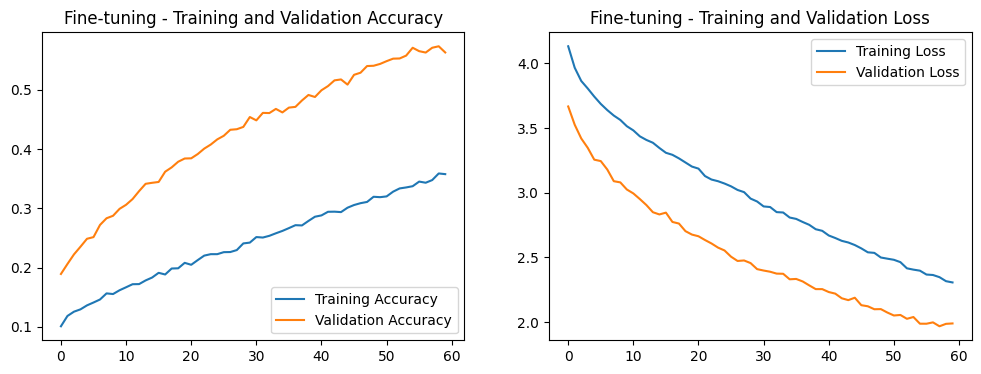

201/201 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step


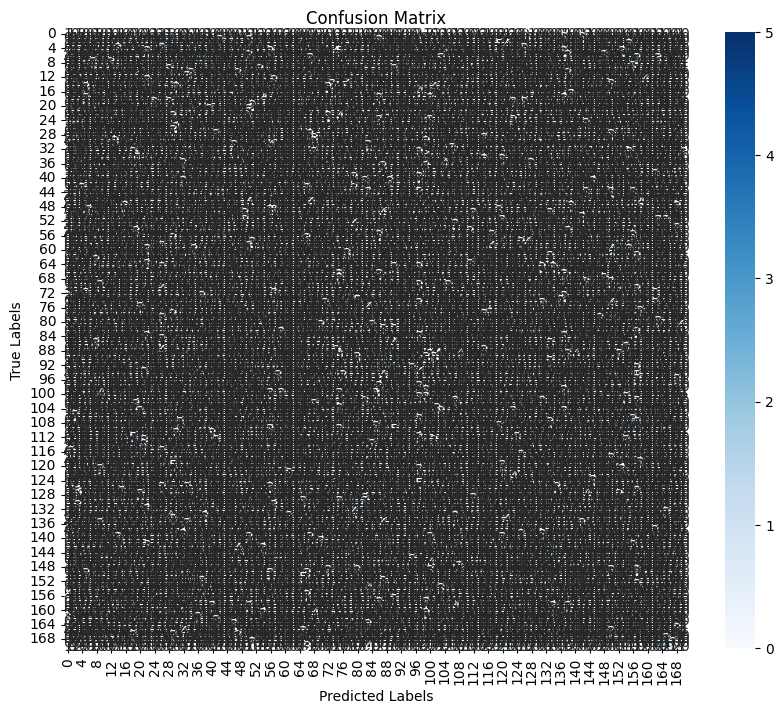


Classification Report:
               precision    recall  f1-score   support

           0     0.0112    0.0116    0.0114        86
           1     0.0000    0.0000    0.0000        60
           2     0.0000    0.0000    0.0000        72
           3     0.0000    0.0000    0.0000        73
           4     0.0217    0.0244    0.0230        82
           5     0.0000    0.0000    0.0000        84
           6     0.0000    0.0000    0.0000        79
           7     0.0000    0.0000    0.0000        87
           8     0.0000    0.0000    0.0000        76
           9     0.0000    0.0000    0.0000        65
          10     0.0141    0.0130    0.0135        77
          11     0.0000    0.0000    0.0000        82
          12     0.0135    0.0133    0.0134        75
          13     0.0000    0.0000    0.0000        74
          14     0.0093    0.0132    0.0109        76
          15     0.0122    0.0141    0.0131        71
          16     0.0143    0.0125    0.0133        80
  

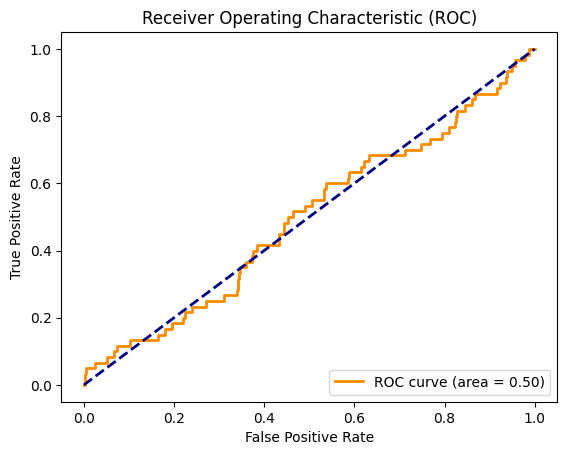


Training ConvNeXtSmall
198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 2, 2, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 171)            │        11,115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,892,363 (190.32 MB)

 Trainable params: 437,675 (1.67 MB)

 Non-trainable params: 49,454,688 (188.65 MB)

Epoch 1/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 105s 106ms/step - accuracy: 0.0066 - loss: 11.5472 - val_accuracy: 0.0109 - val_loss: 8.0315 - learning_rate: 1.0000e-04
Epoch 2/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 51s 85ms/step - accuracy: 0.0075 - loss: 7.4450 - val_accuracy: 0.0120 - val_loss: 6.1956 - learning_rate: 1.0000e-04
Epoch 3/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.0099 - loss: 6.0246 - val_accuracy: 0.0164 - val_loss: 5.5961 - learning_rate: 1.0000e-04
Epoch 4/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 50s 82ms/step - accuracy: 0.0125 - loss: 5.5506 - val_accuracy: 0.0156 - val_loss: 5.3485 - learning_rate: 1.0000e-04
Epoch 5/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 51s 84ms/step - accuracy: 0.0134 - loss: 5.3462 - val_accuracy: 0.0240 - val_loss: 5.2020 - learning_rate: 1.0000e-04
Epoch 6/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 51s 84ms/step - accuracy: 0.0161 - loss: 5.2244 - val_accuracy: 0.0248 - val_loss: 5.1059 - learning_rate: 1.0000e-04
Epoch 7/40
602/602 ━━━━━━━━━━━━━━━━━━━━ 51s 84ms/

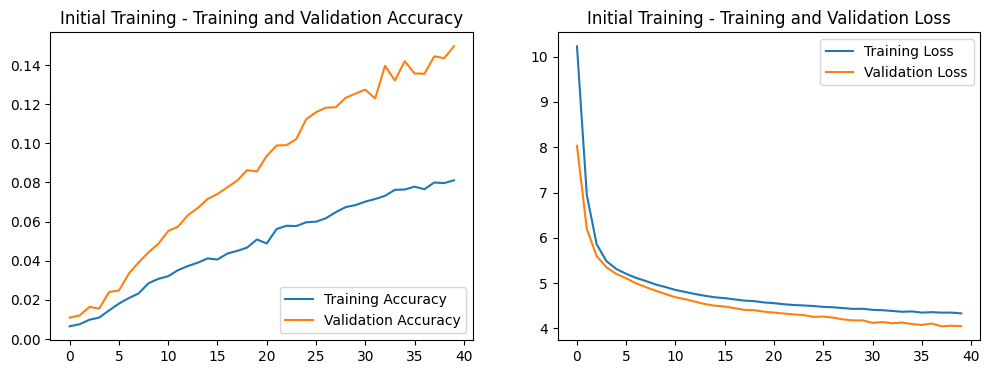


Initial Training CPU Time: 2073.42 seconds

Fine-tuning the model
Epoch 1/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 316s 377ms/step - accuracy: 0.0877 - loss: 4.2469 - val_accuracy: 0.1592 - val_loss: 3.8042 - learning_rate: 1.0000e-05
Epoch 2/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 211s 350ms/step - accuracy: 0.1009 - loss: 4.0715 - val_accuracy: 0.1707 - val_loss: 3.6858 - learning_rate: 1.0000e-05
Epoch 3/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 211s 350ms/step - accuracy: 0.1046 - loss: 3.9893 - val_accuracy: 0.1891 - val_loss: 3.5902 - learning_rate: 1.0000e-05
Epoch 4/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 210s 349ms/step - accuracy: 0.1152 - loss: 3.9238 - val_accuracy: 0.1960 - val_loss: 3.5117 - learning_rate: 1.0000e-05
Epoch 5/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 210s 349ms/step - accuracy: 0.1201 - loss: 3.8744 - val_accuracy: 0.2113 - val_loss: 3.4366 - learning_rate: 1.0000e-05
Epoch 6/60
602/602 ━━━━━━━━━━━━━━━━━━━━ 211s 349ms/step - accuracy: 0.1261 - loss: 3.8156 - val_accuracy: 0.2141 - val_loss: 3.3839 -

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import time

# Enable TPU or Mirrored Strategy for multi-GPU, fallback to None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Constants
IMG_SIZE = 64
BATCH_SIZE = 64
NUM_CLASSES = 171
EPOCHS = 100
INITIAL_EPOCHS = 40  # Number of epochs for initial training with frozen base
FINE_TUNE_EPOCHS = 60  # Number of epochs for fine-tuning

# Data loading and preprocessing
def load_data():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '/kaggle/input/dataset-new/Dataset(64x64)',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        validation_split=0.25,
        subset='training',
        seed=123
    )
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '/kaggle/input/dataset-new/Dataset(64x64)',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        validation_split=0.25,
        subset='validation',
        seed=123
    )
    
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.prefetch(AUTOTUNE)
    val_ds = val_ds.prefetch(AUTOTUNE)
    
    return train_ds, val_ds

def get_base_model(model_name, input_shape):
    if model_name == "ConvNeXtTiny":
        base_model = tf.keras.applications.convnext.ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "ConvNeXtSmall":
        base_model = tf.keras.applications.convnext.ConvNeXtSmall(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "ConvNeXtBase":
        base_model = tf.keras.applications.convnext.ConvNeXtBase(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "ConvNeXtLarge":
        base_model = tf.keras.applications.convnext.ConvNeXtLarge(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "ConvNeXtXLarge":
        base_model = tf.keras.applications.convnext.ConvNeXtXLarge(include_top=False, weights='imagenet', input_shape=input_shape)
    return base_model

def create_model(model_name, input_shape, trainable=False):
    with strategy.scope():  # Ensuring strategy is consistently used here
        base_model = get_base_model(model_name, input_shape)
        base_model.trainable = trainable
        
        inputs = tf.keras.Input(shape=input_shape)
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(0.8)(x)
        x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(0.5)(x)
        outputs = Dense(NUM_CLASSES, activation='softmax')(x)
        
        model = Model(inputs, outputs)
        
        model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        model.summary()

        return model

def get_callbacks(model_name, stage="initial"):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'/kaggle/working/conv_best_{model_name}_{stage}.keras', monitor='val_accuracy', save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    return [early_stopping, model_checkpoint, reduce_lr]

def plot_metrics(history, stage):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{stage} - Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{stage} - Training and Validation Loss')
    plt.show()

def plot_confusion_matrix(model, val_ds):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = np.argmax(model.predict(val_ds), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

def plot_roc_auc(model, val_ds):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1], pos_label=1)  # Adjust for binary case or per class
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate_model(model_name, train_ds, val_ds):
    print(f"\nTraining {model_name}")
    
    # Creating the model within strategy scope for fine-tuning phase
    with strategy.scope():
        model = create_model(model_name, (IMG_SIZE, IMG_SIZE, 3), trainable=False)
        start_time = time.time()
        initial_history = model.fit(train_ds, validation_data=val_ds, epochs=INITIAL_EPOCHS, callbacks=get_callbacks(model_name, "initial"))
        end_time = time.time()
        plot_metrics(initial_history, "Initial Training")
        
        print(f"\nInitial Training CPU Time: {end_time - start_time:.2f} seconds")
        
        print("\nFine-tuning the model")
        base_model = model.layers[1]
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) // 3
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=FINE_TUNE_EPOCHS, callbacks=get_callbacks(model_name, "fine_tune"))
        plot_metrics(fine_tune_history, "Fine-tuning")
        
        plot_confusion_matrix(model, val_ds)
        plot_roc_auc(model, val_ds)
    
    return model, initial_history, fine_tune_history

def main():
    train_ds, val_ds = load_data()
    models = ["ConvNeXtTiny", "ConvNeXtSmall", "ConvNeXtBase", "ConvNeXtLarge", "ConvNeXtXLarge"]
    for model_name in models:
        model, initial_history, fine_tune_history = train_and_evaluate_model(model_name, train_ds, val_ds)

if __name__ == "__main__":
    main()


# New 28-11-24

2.16.1
Found 51300 files belonging to 171 classes.
Using 35910 files for training.
Found 51300 files belonging to 171 classes.
Using 15390 files for validation.
Class names: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217',

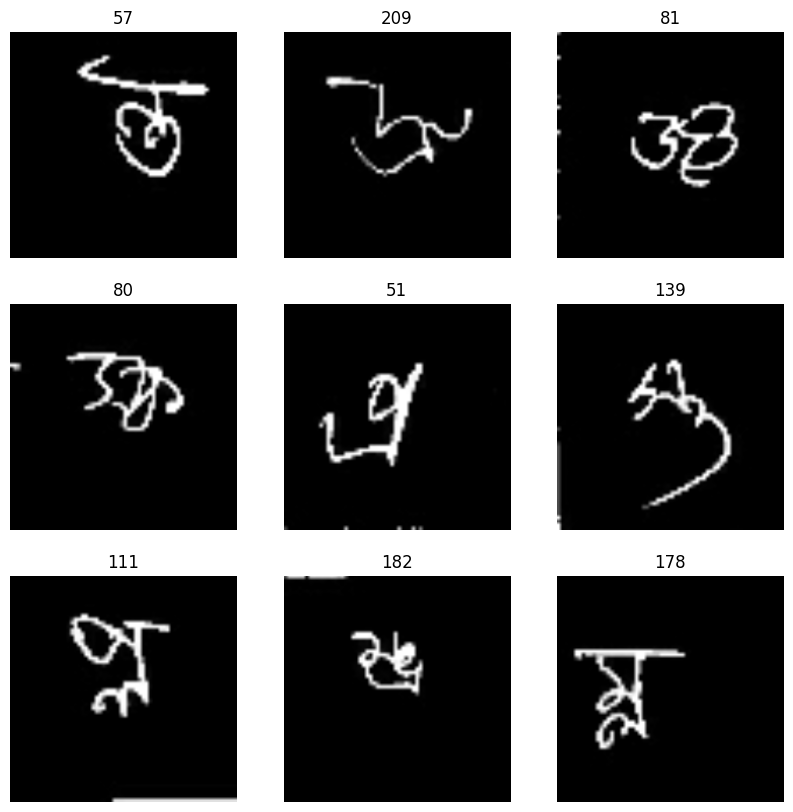

Normalized image range: 0.0 1.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 171)            │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,396,907 (32.03 MB)

 Trainable params: 5,168,043 (19.71 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/50


I0000 00:00:1731899257.772815     569 service.cc:145] XLA service 0x7991640020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731899257.772864     569 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731899257.772870     569 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-18 03:07:44.564795: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[256,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,32,112,112]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-18 03:07:44.577050:

KeyboardInterrupt: 

In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
print(tf.__version__)

batch_size = 256
img_height = 224
img_width = 224
lr_rate = 1e-5
lr_mode = 'cos'
epochs = 50

# Using augmented dataset for all splits
data_dir = pathlib.Path('/kaggle/input/dataset-new/Dataset(64x64)').with_suffix('')

# First split: 70% for training, 30% for remaining
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,  # 30% for validation and test combined
  subset="training",     # This will be our 70% training set
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Get the remaining 30% of the data
remaining_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Split the remaining 30% into validation (20%) and test (10%)
val_batches = tf.data.experimental.cardinality(remaining_ds)
val_size = (val_batches * 2) // 3  # 2/3 of the remaining data for validation (20% of total)
test_size = val_batches - val_size  # 1/3 of the remaining data for testing (10% of total)

val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

class_names = train_ds.class_names
print("Class names:", class_names)

# Visualization of training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print("Normalized image range:", np.min(first_image), np.max(first_image))

base_model = keras.applications.MobileNet(
    weights='imagenet',
    input_shape=(img_width, img_height, 3),
    include_top=False)
base_model.trainable = False

inputs = keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)

outputs = keras.layers.Dense(len(class_names))(x)

model = keras.Model(inputs, outputs)

model.summary()

# def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
#     lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
#     lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75
    
#     def lrfn(epoch):
#         if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
#         elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
#         elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
#         elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
#         elif mode == 'cos':
#             decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
#             decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
#             phase = math.pi * decay_epoch_index / decay_total_epochs
#             lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
#         return lr
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    # Increased initial and maximum learning rates
    lr_start = 1e-4  # Increased from 5e-5 for faster initial learning
    lr_max = 1e-5 * batch_size  # Increased from 6e-6 for higher peak learning
    lr_min = 5e-6  # Decreased from 1e-5 for better fine-tuning
    
    # Modified epoch phases
    lr_ramp_ep = 2  # Decreased from 3 for faster warmup
    lr_sus_ep = 1   # Added sustain period
    lr_decay = 0.85  # Increased from 0.75 for smoother decay
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            # Steeper linear ramp
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        
        elif epoch < lr_ramp_ep + lr_sus_ep:
            # Hold at max for sustain period
            lr = lr_max
        
        elif mode == 'exp':
            # More gradual exponential decay
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        
        elif mode == 'step':
            # More frequent step decay
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 1)  # Changed from // 2
        
        elif mode == 'cos':
            # Enhanced cosine decay
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 2  # Adjusted from +3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        
        return lr   
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

lr_cb = get_lr_callback(batch_size, mode=lr_mode, epochs=epochs)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=val_ds)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_ds)

# Get predictions and true labels
all_predictions = []
all_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predictions = tf.nn.softmax(predictions)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Convert predictions to class labels
predicted_classes = np.argmax(all_predictions, axis=1)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(all_labels, predicted_classes, target_names=class_names))

# Create and plot confusion matrix
cm = confusion_matrix(all_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(all_labels == i, all_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Print overall metrics
print("\nOverall Test Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Number of devices: 2
Found 51300 files belonging to 171 classes.
Using 35910 files for training.
Found 51300 files belonging to 171 classes.
Using 15390 files for validation.
Class names: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215',

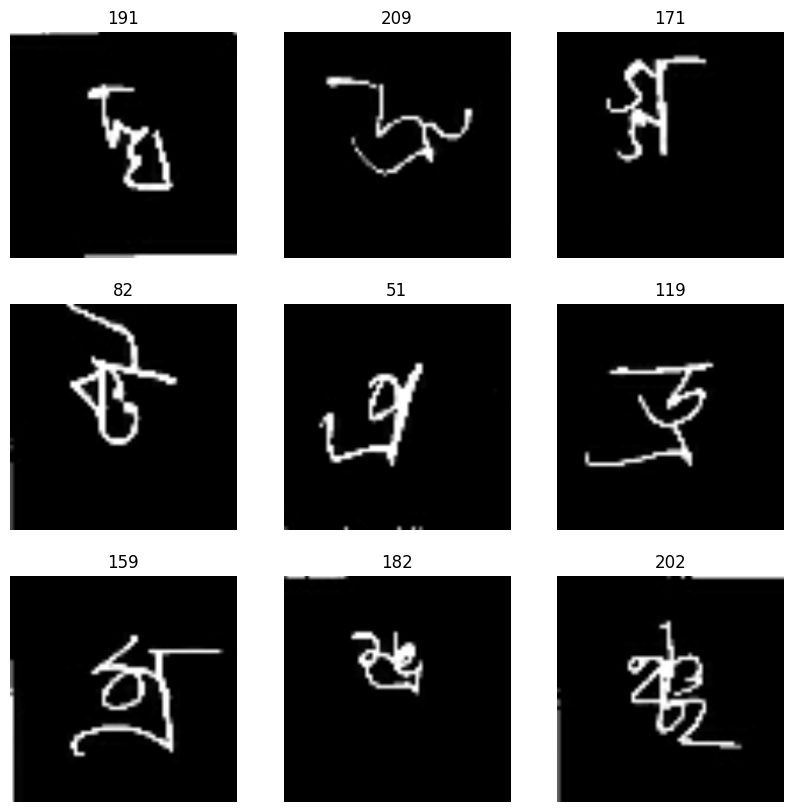

Normalized image range: 0.0 1.0


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/50
  2/281 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - accuracy: 0.0000e+00 - loss: 5.4107   

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


281/281 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.0000e+00 - loss: 5.3219 - val_accuracy: 0.0057 - val_loss: 5.1923 - learning_rate: 1.0000e-04
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 4.1704e-05 - loss: 5.2860 - val_accuracy: 0.0066 - val_loss: 5.1590 - learning_rate: 6.9000e-04
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.0156 - loss: 5.0769 - val_accuracy: 0.0105 - val_loss: 5.1591 - learning_rate: 0.0013
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.0157 - loss: 4.9073 - val_accuracy: 0.0068 - val_loss: 5.2000 - learning_rate: 0.0013
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.0313 - loss: 4.8724 - val_accuracy: 0.0066 - val_loss: 5.2497 - learning_rate: 0.0013
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.0390 - loss: 4.7635 - val_accuracy: 0.0096 - val_loss: 5.3052 - learning_rate: 0.0013
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.0312 - lo

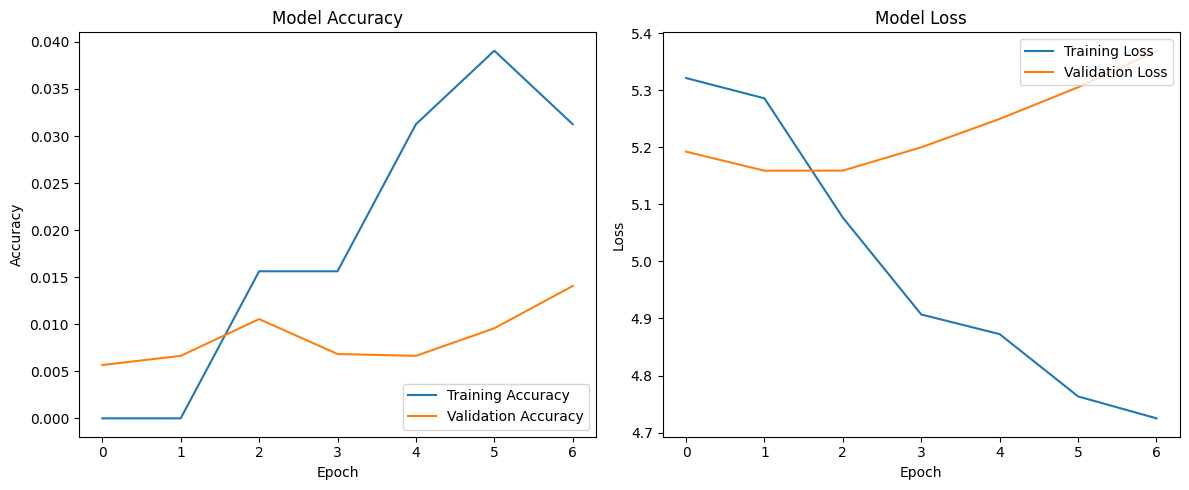


Evaluating model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.0026 - loss: 5.1683

Generating predictions...


ValueError: It looks like you are using a PerReplica object while not inside a replica context, which is not supported. Try running your op or function inside a replica context by using `strategy.run`

In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pathlib
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Configure GPUs for parallel processing
strategy = tf.distribute.MirroredStrategy()
print('Number of devices:', strategy.num_replicas_in_sync)

# Adjust batch size for T4 x2 (can be larger due to distributed training)
batch_size = 128  # Increased for dual GPUs
img_height = 224
img_width = 224
lr_rate = 1e-5
lr_mode = 'cos'
epochs = 50

def create_dataset(data_dir, validation_split, subset, seed=123):
    return tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset=subset,
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )

# Enable mixed precision for better GPU utilization
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load datasets
data_dir = pathlib.Path('/kaggle/input/dataset-new/Dataset(64x64)').with_suffix('')

train_ds = create_dataset(data_dir, 0.3, "training")
remaining_ds = create_dataset(data_dir, 0.3, "validation")

val_batches = tf.data.experimental.cardinality(remaining_ds)
val_size = (val_batches * 2) // 3
test_size = val_batches - val_size

val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

class_names = train_ds.class_names
print("Class names:", class_names)

# Visualization of training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Optimize data pipeline for T4 GPUs
def prepare_dataset(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Optimize preprocessing pipeline
    ds = ds.cache()  # Cache after loading (T4 has enough memory)
    ds = ds.map(
        lambda x, y: (tf.cast(x, tf.float16) / 255.0, y),  # Use float16 for mixed precision
        num_parallel_calls=AUTOTUNE,
        deterministic=False
    )
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)
test_ds = prepare_dataset(test_ds)

# Verify normalization
for images, labels in train_ds.take(1):
    first_image = images[0]
    print("Normalized image range:", np.min(first_image), np.max(first_image))

# Create distributed model
# Create distributed model
with strategy.scope():
    def create_model(num_classes):
        base_model = keras.applications.MobileNet(
            weights='imagenet',
            input_shape=(img_width, img_height, 3),
            include_top=False,
            pooling='avg'
        )
        base_model.trainable = False
        
        model = keras.Sequential([
            base_model,
            keras.layers.Dense(512, activation='relu'),  # First dense layer
            keras.layers.Dropout(0.5),  # First dropout layer
            keras.layers.Dense(256, activation='relu'),  # Second dense layer
            keras.layers.Dropout(0.4),  # Added second dropout layer
            keras.layers.Dense(128, activation='relu'),  # Added third dense layer
            keras.layers.Dense(num_classes)
        ])
        return model

    model = create_model(len(class_names))
    
    # Use mixed precision optimizer
    optimizer = keras.optimizers.Adam(learning_rate=lr_rate)
    optimizer = keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

model.summary()

# Learning rate scheduling
def get_lr_schedule(batch_size=128, epochs=50):
    """Returns the learning rate schedule function."""
    lr_start, lr_max, lr_min = 1e-4, 1e-5 * batch_size, 5e-6
    lr_ramp_ep, lr_sus_ep = 2, 1
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            return (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            return lr_max
        else:
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 2
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            return (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
            
    return lrfn

def get_lr_callback(batch_size=128, epochs=50):
    """Returns the LearningRateScheduler callback."""
    return keras.callbacks.LearningRateScheduler(get_lr_schedule(batch_size, epochs), verbose=False)

def plot_lr_schedule(batch_size=128, epochs=50):
    """Plots the learning rate schedule."""
    epochs_range = range(epochs)
    lr_schedule_fn = get_lr_schedule(batch_size, epochs)
    lr_values = [lr_schedule_fn(epoch) for epoch in epochs_range]
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, lr_values)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

# Training callbacks
# Modify the callback creation line
callbacks = [
   get_lr_callback(batch_size, epochs=epochs),
   keras.callbacks.EarlyStopping(
       monitor='val_loss',
       patience=5,
       restore_best_weights=True
   ),
   keras.callbacks.ModelCheckpoint(
       '/kaggle/working/best_model.keras',  # Changed to .keras extension
       monitor='val_loss',
       save_best_only=True,
       save_weights_only=False  # Set to False since using .keras format
   ),
   keras.callbacks.ReduceLROnPlateau(
       monitor='val_loss',
       factor=0.2,
       patience=2,
       min_lr=1e-6
   )
]

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Efficient evaluation function for distributed setup
@tf.function
def distributed_predict(images):
    return strategy.run(lambda x: model(x, training=False), args=(images,))

def evaluate_model_by_batches(model, dataset):
    all_predictions = []
    all_labels = []
    
    for batch_images, batch_labels in dataset:
        batch_predictions = distributed_predict(batch_images)
        batch_predictions = tf.nn.softmax(batch_predictions)
        
        all_predictions.append(batch_predictions.numpy())
        all_labels.append(batch_labels.numpy())
    
    return np.concatenate(all_predictions), np.concatenate(all_labels)

# Evaluate model
print("\nEvaluating model...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

# Generate predictions
print("\nGenerating predictions...")
predictions, labels = evaluate_model_by_batches(model, test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(labels, predicted_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(labels, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(labels == i, predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right", bbox_to_anchor=(1.2, 0))
plt.tight_layout()
plt.show()

# Plot misclassified examples
def plot_misclassified_examples(images_ds, predictions, labels, class_names, num_examples=9):
    plt.figure(figsize=(15, 15))
    count = 0
    for images, true_labels in images_ds:
        batch_predictions = model.predict(images, verbose=0)
        batch_predictions = np.argmax(batch_predictions, axis=1)
        
        for i, (pred, true) in enumerate(zip(batch_predictions, true_labels)):
            if pred != true and count < num_examples:
                ax = plt.subplot(3, 3, count + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(f'True: {class_names[true]}\nPred: {class_names[pred]}')
                plt.axis('off')
                count += 1
        
        if count >= num_examples:
            break
    
    plt.tight_layout()
    plt.show()

print("\nDisplaying misclassified examples...")
plot_misclassified_examples(test_ds, predicted_classes, labels, class_names)

# Print overall metrics
print("\nOverall Test Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot class-wise accuracy
class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_accuracies)
plt.title('Class-wise Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2.16.1
Found 51300 files belonging to 171 classes.
Using 35910 files for training.
Found 51300 files belonging to 171 classes.
Using 15390 files for validation.
Class names: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217',

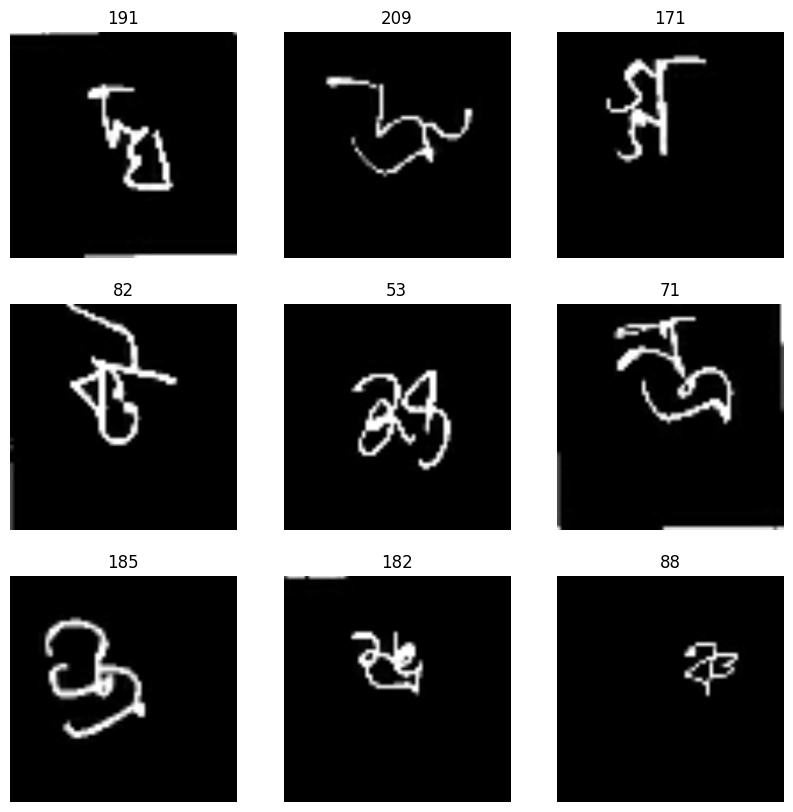

Normalized image range: 0.0 1.0
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ NASNet (Functional)             │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     4,866,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 171)            │        11,115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,295,167 (35.46 MB)

 Trainable params: 5,025,451 (19.17 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

Epoch 1/30


I0000 00:00:1732086185.927395     105 service.cc:145] XLA service 0x78e7e80378d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732086185.927446     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732086185.927452     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/562 ━━━━━━━━━━━━━━━━━━━━ 5:49:00 37s/step - accuracy: 0.0000e+00 - loss: 5.7463

I0000 00:00:1732086204.476045     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/562 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0073 - loss: 5.1824

2024-11-20 07:04:16.679129: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1629] failed to alloc 17179869184 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [ ]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
print(tf.__version__)

batch_size = 64
img_height = 224
img_width = 224
lr_rate = 5e-6
lr_mode = 'cos'
epochs = 30

# Using augmented dataset for all splits
data_dir = pathlib.Path('/kaggle/input/dataset-new/Dataset(64x64)').with_suffix('')

# First split: 70% for training, 30% for remaining
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,  # 30% for validation and test combined
  subset="training",     # This will be our 70% training set
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Get the remaining 30% of the data
remaining_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Split the remaining 30% into validation (20%) and test (10%)
val_batches = tf.data.experimental.cardinality(remaining_ds)
val_size = (val_batches * 2) // 3  # 2/3 of the remaining data for validation (20% of total)
test_size = val_batches - val_size  # 1/3 of the remaining data for testing (10% of total)

val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

class_names = train_ds.class_names
print("Class names:", class_names)

# Visualization of training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print("Normalized image range:", np.min(first_image), np.max(first_image))

base_model = keras.applications.NASNetMobile(
    weights='imagenet',
    input_shape=(img_width, img_height, 3),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.8)(x)
x = keras.layers.Dense(64, activation='relu')(x) 
outputs = keras.layers.Dense(len(class_names))(x)

model = keras.Model(inputs, outputs)

model.summary()

def get_lr_callback(batch_size=32, mode='cos', epochs=40, plot=False):
    lr_start, lr_max, lr_min = 3e-4, 3e-5 * batch_size, 5e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 1, 0.75
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr
    
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

lr_cb = get_lr_callback(batch_size, mode=lr_mode, epochs=epochs)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=val_ds)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_ds)

# Get predictions and true labels
all_predictions = []
all_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predictions = tf.nn.softmax(predictions)
    all_predictions.extend(predictions.numpy())
    all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Convert predictions to class labels
predicted_classes = np.argmax(all_predictions, axis=1)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(all_labels, predicted_classes, target_names=class_names))

# Create and plot confusion matrix
cm = confusion_matrix(all_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate and plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(all_labels == i, all_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Print overall metrics
print("\nOverall Test Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 51300 files belonging to 171 classes.
Using 35910 files for training.
Found 51300 files belonging to 171 classes.
Using 35910 files for training.
Found 51300 files belonging to 171 classes.
Using 15390 files for validation.
Class names: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', 

I0000 00:00:1732086663.618052     257 service.cc:145] XLA service 0x797420013fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732086663.618112     257 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732086663.618118     257 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   7/1123 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.0049 - loss: 5.7289      

I0000 00:00:1732086674.945003     257 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1123/1123 ━━━━━━━━━━━━━━━━━━━━ 96s 38ms/step - accuracy: 0.0127 - loss: 5.1615 - val_accuracy: 0.0893 - val_loss: 4.4890 - learning_rate: 3.0000e-04
Epoch 2/30
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.0817 - loss: 4.3559 - val_accuracy: 0.3159 - val_loss: 3.2223 - learning_rate: 5.2000e-04
Epoch 3/30
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.1870 - loss: 3.5665 - val_accuracy: 0.3871 - val_loss: 2.7408 - learning_rate: 7.4000e-04
Epoch 4/30
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.2396 - loss: 3.2603 - val_accuracy: 0.4271 - val_loss: 2.5468 - learning_rate: 9.6000e-04
Epoch 5/30
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.2752 - loss: 3.0758 - val_accuracy: 0.4493 - val_loss: 2.4413 - learning_rate: 9.6000e-04
Epoch 6/30
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.2880 - loss: 2.9879 - val_accuracy: 0.4508 - val_loss: 2.2920 - learning_rate: 9.5720e-04
Epoch 7/30
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/

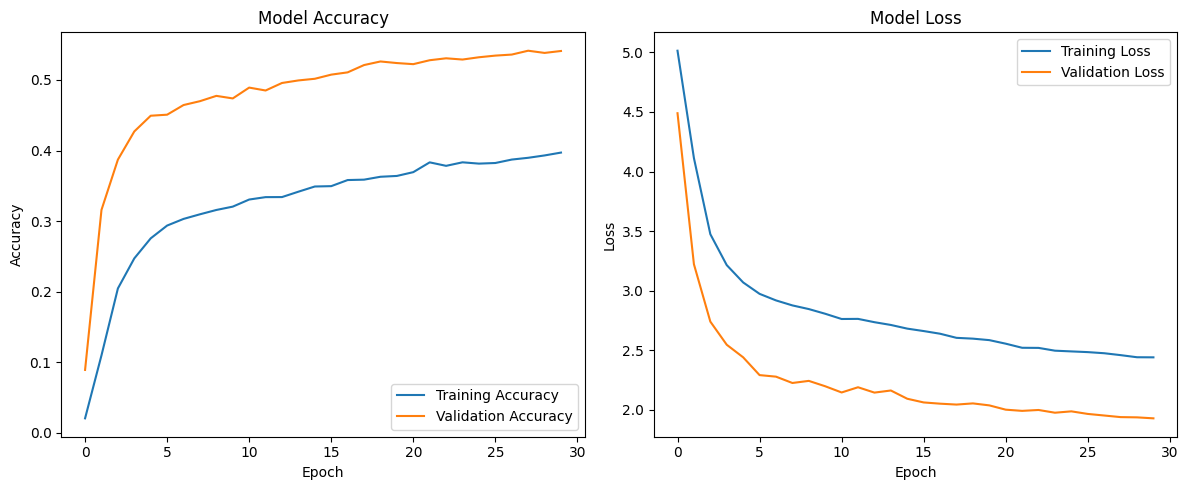

161/161 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.5312 - loss: 1.9609

Test Loss: 1.9331
Test Accuracy: 0.5383

Classification Report:
              precision    recall  f1-score   support

         100       0.79      0.59      0.68        37
         101       0.61      0.86      0.72        22
         102       0.53      0.74      0.62        27
         103       0.65      0.61      0.63        28
         104       0.56      0.61      0.59        36
         105       0.58      0.78      0.67        37
         106       0.68      0.66      0.67        32
         107       0.61      0.51      0.56        39
         108       0.56      0.32      0.41        28
         109       0.58      0.58      0.58        26
         110       0.64      0.23      0.34        30
         111       0.43      0.50      0.46        30
         112       0.64      0.72      0.68        29
         113       0.41      0.33      0.37        36
         114       0.71      0.77      0.74    

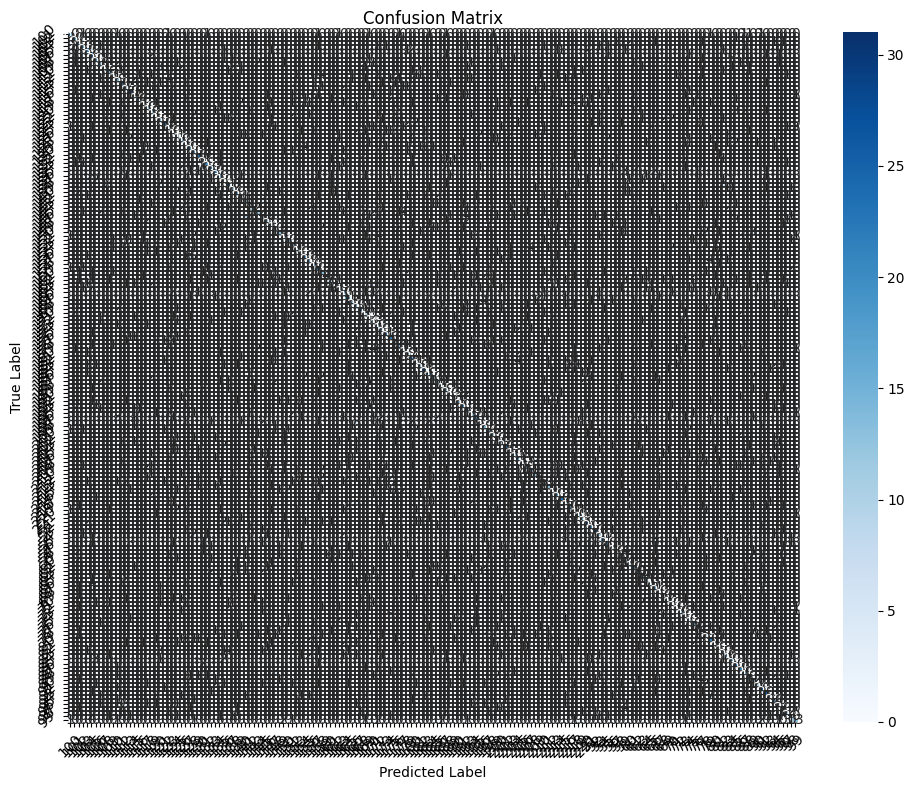

In [2]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import gc

# Enable memory growth to prevent GPU from allocating all memory at once
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Reduce batch size and image dimensions to decrease memory usage
batch_size = 32  # Reduced from 64
img_height = 160  # Reduced from 224
img_width = 160   # Reduced from 224
lr_rate = 5e-6
lr_mode = 'cos'
epochs = 30

# Clear any existing models/sessions
tf.keras.backend.clear_session()
gc.collect()

def load_datasets(data_dir):
    # First, create initial datasets to get class names
    initial_train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    class_names = initial_train_ds.class_names

    # Now load the datasets with optimizations
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    remaining_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    # Split remaining data into validation and test
    val_batches = tf.data.experimental.cardinality(remaining_ds)
    val_size = (val_batches * 2) // 3
    test_size = val_batches - val_size

    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    # Optimize dataset performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

def create_model(num_classes):
    # Use a more memory-efficient base model
    base_model = keras.applications.MobileNetV2(
        weights='imagenet',
        input_shape=(img_width, img_height, 3),
        include_top=False)
    
    base_model.trainable = False

    # Use mixed precision for better memory efficiency
    policy = keras.mixed_precision.Policy('mixed_float16')
    keras.mixed_precision.set_global_policy(policy)

    inputs = keras.Input(shape=(img_width, img_height, 3))
    x = keras.layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(num_classes, dtype='float32')(x)

    return keras.Model(inputs, outputs)

def get_lr_callback(batch_size=32, mode='cos', epochs=40):
    lr_start, lr_max, lr_min = 3e-4, 3e-5 * batch_size, 5e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 1, 0.75
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr
    
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_ds, class_names):
    # Get predictions in smaller batches
    all_predictions = []
    all_labels = []
    
    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        predictions = tf.nn.softmax(predictions)
        all_predictions.extend(predictions.numpy())
        all_labels.extend(labels.numpy())
        
        # Clear memory after each batch
        tf.keras.backend.clear_session()
        gc.collect()

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predicted_classes = np.argmax(all_predictions, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, predicted_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return all_predictions, all_labels

def main():
    # Load data
    data_dir = pathlib.Path('/kaggle/input/dataset-new/Dataset(64x64)').with_suffix('')
    train_ds, val_ds, test_ds, class_names = load_datasets(data_dir)
    print("Class names:", class_names)

    # Create and compile model
    model = create_model(len(class_names))
    
    # Set up callbacks
    lr_cb = get_lr_callback(batch_size, mode=lr_mode, epochs=epochs)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[early_stopping, lr_cb],
        validation_data=val_ds
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Generate and plot evaluation metrics
    evaluate_model(model, test_ds, class_names)

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import gc

# Enable memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except RuntimeError as e:
        print(f"GPU memory growth error: {e}")

# Adjusted hyperparameters for better performance
batch_size = 32
img_height = 224
img_width = 224
initial_lr = 1e-4
min_lr = 1e-6
epochs = 50

# Clear session and garbage collect
tf.keras.backend.clear_session()
gc.collect()

# Create augmentation layers outside the function
rotation_layer = tf.keras.layers.RandomRotation(0.2)
zoom_layer = tf.keras.layers.RandomZoom(0.2)

def apply_augmentation(images, labels):
    """Apply data augmentation to images."""
    try:
        # Convert images to float32 and scale to [0, 1]
        images = tf.cast(images, tf.float32) / 255.0
        
        # Apply augmentations
        images = tf.image.random_flip_left_right(images)
        images = tf.image.random_flip_up_down(images)
        images = tf.image.random_brightness(images, 0.2)
        images = tf.image.random_contrast(images, 0.8, 1.2)
        images = tf.image.random_saturation(images, 0.8, 1.2)
        
        # Apply rotation and zoom using global layers
        images = rotation_layer(images)
        images = zoom_layer(images)
        
        # Ensure values are in [0, 1]
        images = tf.clip_by_value(images, 0.0, 1.0)
        
        # Scale back to [0, 255]
        images = images * 255.0
        
        return images, labels
    except Exception as e:
        print(f"Error in augmentation: {e}")
        return images, labels

def load_datasets(data_dir):
    """Load and prepare datasets."""
    try:
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"Data directory not found: {data_dir}")

        # Initial dataset to get class names
        initial_train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.3,
            subset="training",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)
        
        class_names = initial_train_ds.class_names
        
        # Load datasets
        train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.3,
            subset="training",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

        remaining_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.3,
            subset="validation",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

        # Split remaining data
        val_batches = tf.data.experimental.cardinality(remaining_ds)
        val_size = (val_batches * 2) // 3
        test_size = val_batches - val_size

        val_ds = remaining_ds.take(val_size)
        test_ds = remaining_ds.skip(val_size)

        # Apply augmentation only to training data
        AUTOTUNE = tf.data.AUTOTUNE
        train_ds = train_ds.map(apply_augmentation, num_parallel_calls=AUTOTUNE)
        
        # Optimize performance
        train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
        test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

        return train_ds, val_ds, test_ds, class_names
    except Exception as e:
        raise Exception(f"Error loading datasets: {e}")

def create_model(num_classes):
    """Create and return the model."""
    try:
        # Use EfficientNetV2B0 as base model
        base_model = keras.applications.EfficientNetV2B0(
            weights='imagenet',
            input_shape=(img_width, img_height, 3),
            include_top=False
        )
        
        # Fine-tune the last few layers
        fine_tune_at = len(base_model.layers) - 30
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        inputs = keras.Input(shape=(img_width, img_height, 3))
        x = inputs  # Remove redundant rescaling since it's handled in preprocessing
        
        # Let base_model handle the input directly
        x = base_model(x, training=True)
        
        # Enhanced feature extraction
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(512, activation='relu')(x)
        x = keras.layers.Dropout(0.4)(x)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dropout(0.3)(x)
        outputs = keras.layers.Dense(num_classes)(x)

        return keras.Model(inputs, outputs)
    except Exception as e:
        raise Exception(f"Error creating model: {e}")

class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    def __init__(self, warmup_epochs=5, total_epochs=50, initial_lr=1e-4, min_lr=1e-6):
        super().__init__()
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.cos_decay_epochs = total_epochs - warmup_epochs
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        
    def on_epoch_begin(self, epoch, logs=None):
        try:
            if epoch < self.warmup_epochs:
                lr = self.initial_lr * ((epoch + 1) / self.warmup_epochs)
            else:
                progress = (epoch - self.warmup_epochs) / self.cos_decay_epochs
                lr = self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * (1 + np.cos(np.pi * progress))
            
            # Set learning rate using keras backend
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except Exception as e:
            print(f"Error in learning rate scheduler: {e}")

def get_callbacks(model_save_path):
    """Get training callbacks."""
    try:
        callbacks = [
            WarmUpCosineDecayScheduler(
                initial_lr=initial_lr,
                min_lr=min_lr
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=min_lr
            ),
            keras.callbacks.ModelCheckpoint(
                model_save_path,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
        ]
        return callbacks
    except Exception as e:
        raise Exception(f"Error creating callbacks: {e}")

def plot_training_history(history):
    """Plot training history."""
    try:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting training history: {e}")

def evaluate_model(model, test_ds, class_names):
    """Evaluate the model and plot metrics."""
    try:
        # Initialize lists to store predictions and labels
        all_predictions = []
        all_labels = []
        
        # Make predictions in smaller batches
        for images, labels in test_ds:
            predictions = model.predict(images, verbose=0)
            predictions = tf.nn.softmax(predictions)
            all_predictions.extend(predictions.numpy())
            all_labels.extend(labels.numpy())
            
            # Clear memory after each batch
            tf.keras.backend.clear_session()
            gc.collect()

        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        predicted_classes = np.argmax(all_predictions, axis=1)

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, predicted_classes, target_names=class_names))

        # Plot confusion matrix
        cm = confusion_matrix(all_labels, predicted_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return all_predictions, all_labels
    except Exception as e:
        print(f"Error in model evaluation: {e}")
        return None, None

def main():
    try:
        # Set model save path
        model_save_path = 'best_model.keras'
        
        # Load data
        data_dir = pathlib.Path('/kaggle/input/dataset-new/Dataset(64x64)').resolve()
        train_ds, val_ds, test_ds, class_names = load_datasets(data_dir)
        print("Class names:", class_names)

        # Create and compile model
        model = create_model(len(class_names))
        
        # Create optimizer with weight decay
        optimizer = keras.optimizers.AdamW(
            learning_rate=initial_lr,
            weight_decay=0.0001
        )
        
        # Compile model
        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        # Get callbacks
        callbacks = get_callbacks(model_save_path)

        # Train model
        history = model.fit(
            train_ds,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=val_ds
        )

        # Plot training history
        plot_training_history(history)

        # Load best model for evaluation
        if os.path.exists(model_save_path):
            model.load_weights(model_save_path)
        
        # Evaluate model
        test_loss, test_accuracy = model.evaluate(test_ds)
        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Detailed evaluation
        evaluate_model(model, test_ds, class_names)

    except Exception as e:
        print(f"Error in main function: {e}")

if __name__ == "__main__":
    main()

Found 51300 files belonging to 171 classes.
Using 35910 files for training.
Found 51300 files belonging to 171 classes.
Using 35910 files for training.
Found 51300 files belonging to 171 classes.
Using 15390 files for validation.
Class names: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from typing import Dict, List, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from typing import Dict, List, Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from torchsummary import torchsummary

# Mish Activation Function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# LAMB Optimizer Implementation
class Lamb(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0, adam=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Lamb, self).__init__(params, defaults)
        self.adam = adam

    def step(self, closure=None):
        loss = None if closure is None else closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                step_size = group['lr']
                weight_norm = p.data.pow(2).sum().sqrt()
                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(p.data, alpha=group['weight_decay'])

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio

                p.data.add_(adam_step, alpha=-step_size * trust_ratio)

        return loss

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.mish1 = Mish()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.mish2 = Mish()
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.mish1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.mish2(out)
        
        return out

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)
        attention = self.sigmoid(attention)
        return x * attention

class CustomRetinopathyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomRetinopathyCNN, self).__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            Mish(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self._make_layer(64, 64, 2)
        self.attention1 = SpatialAttention()
        
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.attention2 = SpatialAttention()
        
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.attention3 = SpatialAttention()
        
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.attention4 = SpatialAttention()
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            Mish(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            Mish(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial(x)
        
        x = self.layer1(x)
        x = self.attention1(x)
        
        x = self.layer2(x)
        x = self.attention2(x)
        
        x = self.layer3(x)
        x = self.attention3(x)
        
        x = self.layer4(x)
        x = self.attention4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.training_time = 0
        
    def update(self, train_loss, val_loss, train_acc, val_acc):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accuracies.append(train_acc)
        self.val_accuracies.append(val_acc)

def plot_metrics(metrics: MetricsTracker):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics.train_losses, label='Train Loss')
    plt.plot(metrics.val_losses, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics.train_accuracies, label='Train Accuracy')
    plt.plot(metrics.val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_prob, num_classes):
    plt.figure(figsize=(10, 8))
    
    for i in range(num_classes):
        y_true_binary = (y_true == i).astype(int)
        y_prob_class = y_prob[:, i]
        
        fpr, tpr, _ = roc_curve(y_true_binary, y_prob_class)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend()
    plt.show()

def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = Lamb(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    early_stopping = EarlyStopping(patience=7)
    metrics = MetricsTracker()
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_targets = []
        val_probabilities = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                val_predictions.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probabilities.extend(F.softmax(outputs, dim=1).cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        metrics.update(train_loss, val_loss, train_acc, val_acc)
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    metrics.training_time = time.time() - start_time
    
    return model, metrics, np.array(val_targets), np.array(val_predictions), np.array(val_probabilities)

def print_final_metrics(metrics, val_targets, val_predictions, val_probabilities, class_names):
    print("\n=== Final Results ===")
    print(f"Training Time: {metrics.training_time:.2f} seconds")
    print(f"Final Validation Accuracy: {metrics.val_accuracies[-1]:.2f}%")
    
    print("\nClassification Report:")
    print(classification_report(val_targets, val_predictions, target_names=class_names))
    
    # Plot metrics
    plot_metrics(metrics)


# Add Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

    # Update these paths according to your Kaggle dataset structure
    train_dir = '/kaggle/input/data-for-aptos/DR_APTOS_T1/Train'
    val_dir = '/kaggle/input/data-for-aptos/DR_APTOS_T1/Train'

    # Create datasets
    train_dataset = CustomDataset(train_dir, transform=transform)
    val_dataset = CustomDataset(val_dir, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model
    num_classes = len(train_dataset.classes)
    model = CustomRetinopathyCNN(num_classes=num_classes).to(device)

    # Print model summary
    print("\nModel Summary:")
    torchsummary.summary(model, (3, 224, 224))

    # Train model
    model, metrics, val_targets, val_predictions, val_probabilities = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100,
        device=device
    )

    # Print and plot final metrics
    print_final_metrics(metrics, val_targets, val_predictions, val_probabilities, 
                       class_names=train_dataset.classes)

    # Plot confusion matrix
    plot_confusion_matrix(val_targets, val_predictions, classes=train_dataset.classes)

    # Plot ROC curves
    plot_roc_curve(val_targets, val_probabilities, num_classes=num_classes)

if __name__ == "__main__":
    main()

In [2]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


Using device: cuda

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              Mish-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              Mish-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             Mish-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
    

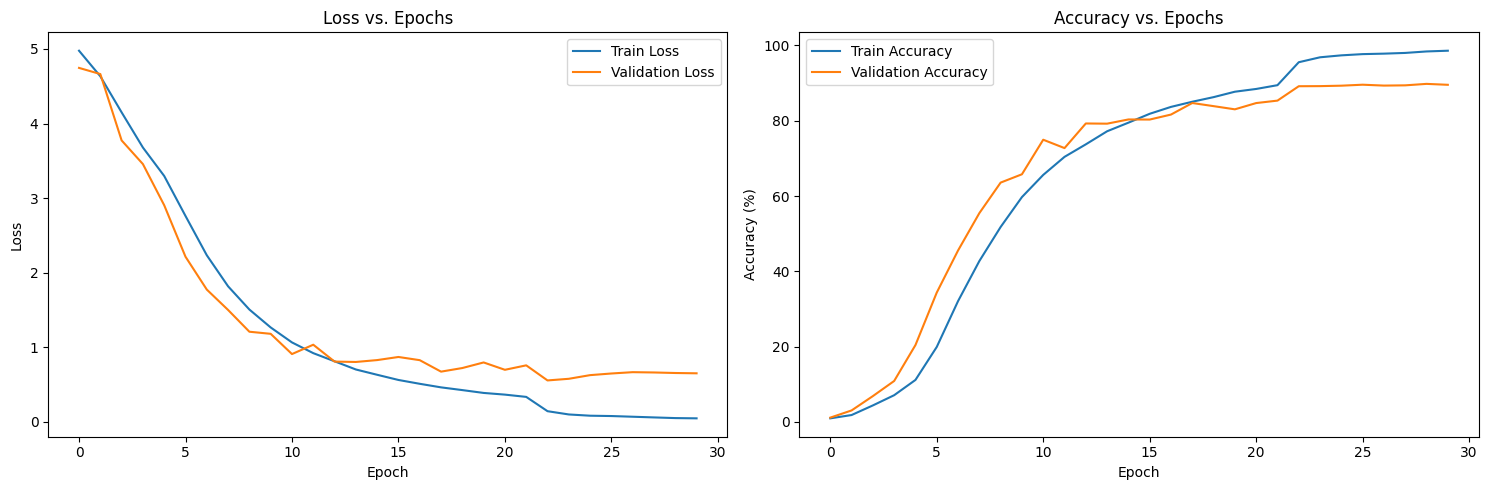


Test Accuracy: 88.54%

Test Set Confusion Matrix:


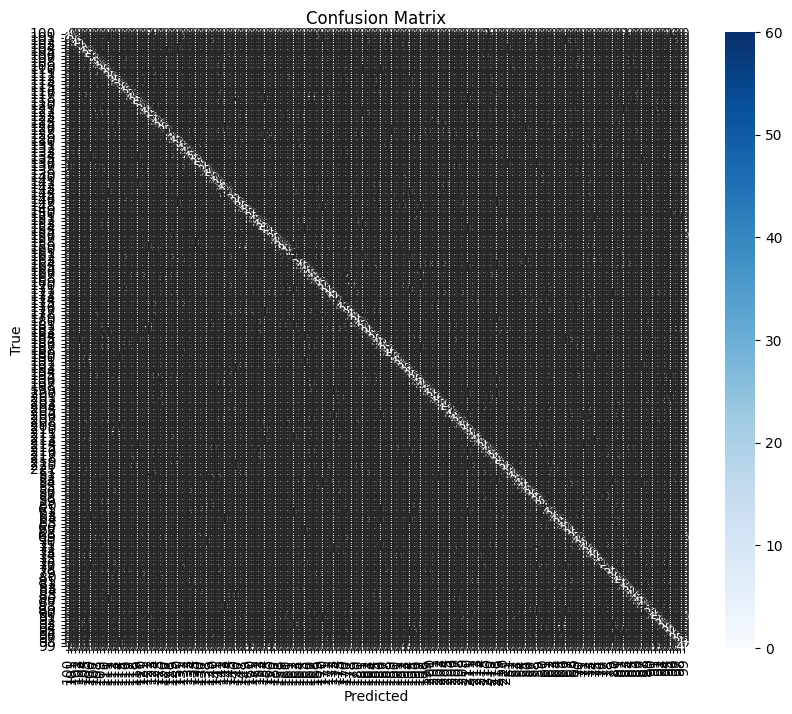


Test Set ROC Curves:


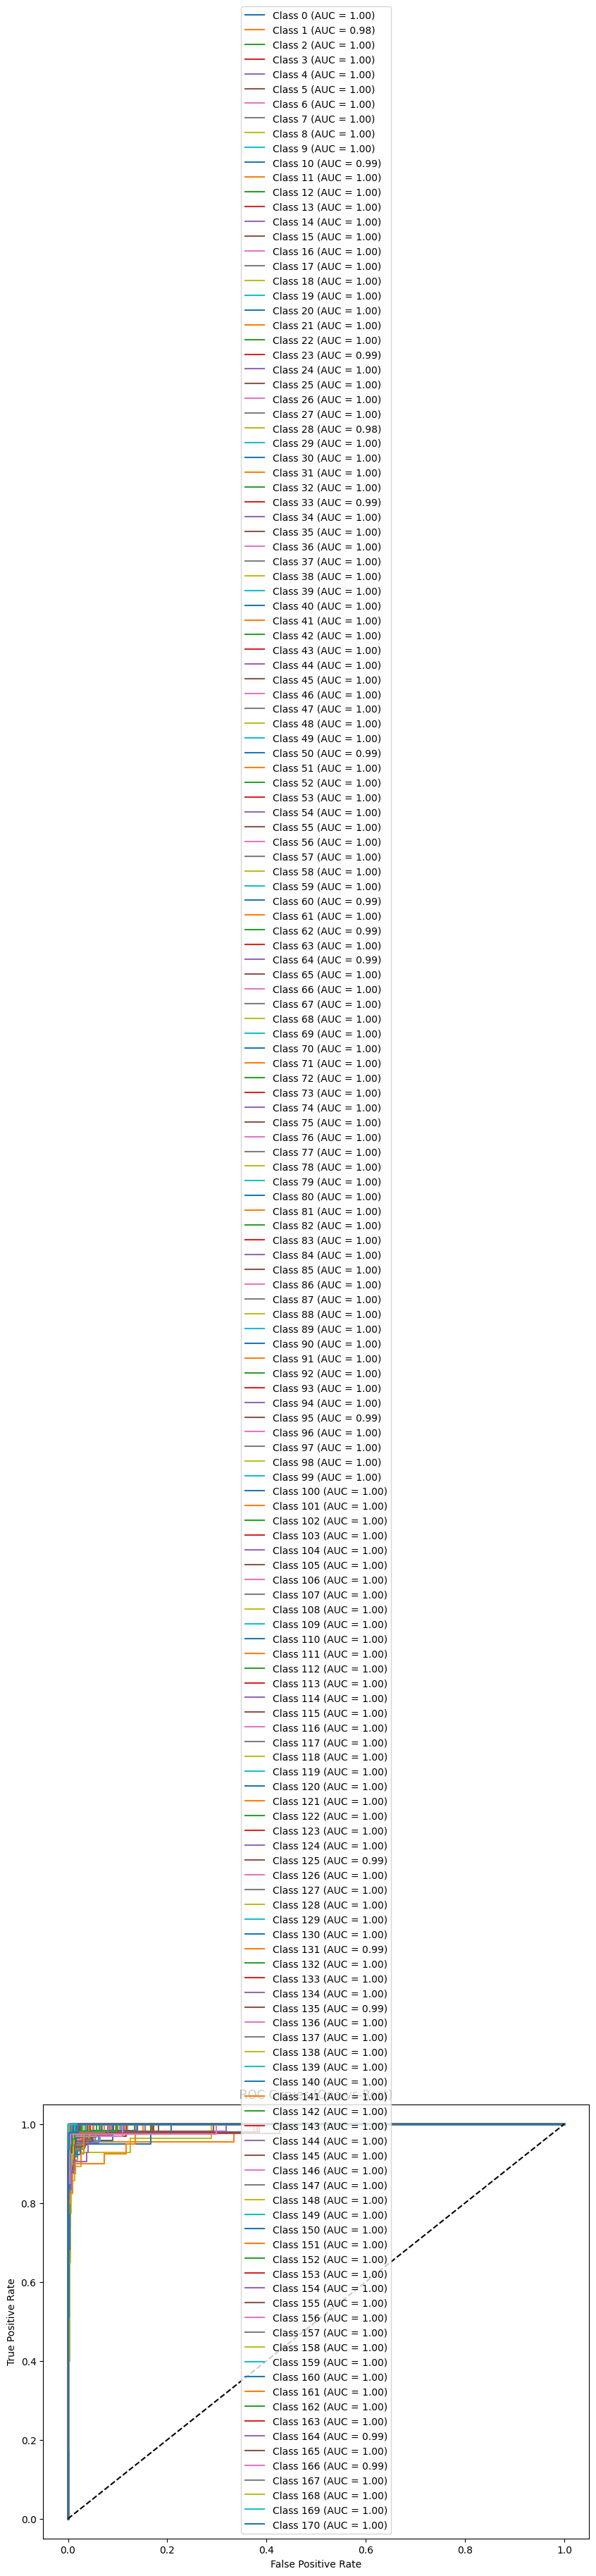


Test Set Classification Report:
              precision    recall  f1-score   support

         100       0.95      0.88      0.91        42
         101       1.00      0.91      0.95        44
         102       0.97      0.82      0.89        44
         103       0.91      0.98      0.94        42
         104       0.93      0.96      0.94        53
         105       0.86      0.98      0.91        49
         106       0.70      0.77      0.73        43
         107       0.90      0.91      0.91        58
         108       0.91      0.98      0.94        41
         109       0.91      0.94      0.92        51
         110       0.78      0.79      0.78        48
         111       0.86      0.92      0.89        39
         112       0.93      0.95      0.94        40
         113       0.76      0.83      0.80        47
         114       0.95      1.00      0.98        60
         115       0.87      0.91      0.89        43
         116       0.94      0.85      0.89     

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from typing import Dict, List, Tuple
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from torchsummary import torchsummary

# Mish Activation Function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# LAMB Optimizer Implementation
class Lamb(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0, adam=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Lamb, self).__init__(params, defaults)
        self.adam = adam

    def step(self, closure=None):
        loss = None if closure is None else closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                step_size = group['lr']
                weight_norm = p.data.pow(2).sum().sqrt()
                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(p.data, alpha=group['weight_decay'])

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio

                p.data.add_(adam_step, alpha=-step_size * trust_ratio)

        return loss

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.mish1 = Mish()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.mish2 = Mish()
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.mish1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.mish2(out)
        
        return out

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)
        attention = self.sigmoid(attention)
        return x * attention

class CustomRetinopathyCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomRetinopathyCNN, self).__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            Mish(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self._make_layer(64, 64, 2)
        self.attention1 = SpatialAttention()
        
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.attention2 = SpatialAttention()
        
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.attention3 = SpatialAttention()
        
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.attention4 = SpatialAttention()
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            Mish(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            Mish(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial(x)
        
        x = self.layer1(x)
        x = self.attention1(x)
        
        x = self.layer2(x)
        x = self.attention2(x)
        
        x = self.layer3(x)
        x = self.attention3(x)
        
        x = self.layer4(x)
        x = self.attention4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.training_time = 0
        
    def update(self, train_loss, val_loss, train_acc, val_acc):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accuracies.append(train_acc)
        self.val_accuracies.append(val_acc)

def plot_metrics(metrics: MetricsTracker):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics.train_losses, label='Train Loss')
    plt.plot(metrics.val_losses, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics.train_accuracies, label='Train Accuracy')
    plt.plot(metrics.val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_prob, num_classes):
    plt.figure(figsize=(10, 8))
    
    for i in range(num_classes):
        y_true_binary = (y_true == i).astype(int)
        y_prob_class = y_prob[:, i]
        
        fpr, tpr, _ = roc_curve(y_true_binary, y_prob_class)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend()
    plt.show()

def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = Lamb(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    early_stopping = EarlyStopping(patience=7)
    metrics = MetricsTracker()
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_targets = []
        val_probabilities = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                val_predictions.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probabilities.extend(F.softmax(outputs, dim=1).cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        metrics.update(train_loss, val_loss, train_acc, val_acc)
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    metrics.training_time = time.time() - start_time
    
    return model, metrics, np.array(val_targets), np.array(val_predictions), np.array(val_probabilities)

def evaluate_model(model, test_loader, device):
    model.eval()
    test_correct = 0
    test_total = 0
    test_predictions = []
    test_targets = []
    test_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
            test_predictions.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
            test_probabilities.extend(F.softmax(outputs, dim=1).cpu().numpy())
    
    test_acc = 100. * test_correct / test_total
    print(f'\nTest Accuracy: {test_acc:.2f}%')
    
    return np.array(test_targets), np.array(test_predictions), np.array(test_probabilities)

def print_final_metrics(metrics, val_targets, val_predictions, val_probabilities, class_names):
    print("\n=== Final Results ===")
    print(f"Training Time: {metrics.training_time:.2f} seconds")
    print(f"Final Validation Accuracy: {metrics.val_accuracies[-1]:.2f}%")
    
    print("\nClassification Report:")
    print(classification_report(val_targets, val_predictions, target_names=class_names))
    
    # Plot metrics
    plot_metrics(metrics)

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.images.append(img_path)
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

    # Update this path according to your dataset location
    data_dir = '/kaggle/input/dataset-new/Dataset(64x64)'

    # Create dataset
    full_dataset = CustomDataset(data_dir, transform=transform)
    
    # Calculate lengths for splits (70% train, 15% validation, 15% test)
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize model
    num_classes = len(full_dataset.classes)
    model = CustomRetinopathyCNN(num_classes=num_classes).to(device)

    # Print model summary
    print("\nModel Summary:")
    torchsummary.summary(model, (3, 224, 224))

    # Train model
    model, metrics, val_targets, val_predictions, val_probabilities = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100,
        device=device
    )

    # Print and plot validation metrics
    print_final_metrics(metrics, val_targets, val_predictions, val_probabilities, 
                       class_names=full_dataset.classes)

    # Evaluate on test set
    test_targets, test_predictions, test_probabilities = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    # Plot confusion matrix for test set
    print("\nTest Set Confusion Matrix:")
    plot_confusion_matrix(test_targets, test_predictions, classes=full_dataset.classes)

    # Plot ROC curves for test set
    print("\nTest Set ROC Curves:")
    plot_roc_curve(test_targets, test_probabilities, num_classes=num_classes)

    print("\nTest Set Classification Report:")
    print(classification_report(test_targets, test_predictions, 
                              target_names=full_dataset.classes))

if __name__ == "__main__":
    main()